# INFORMACIÓN DEL PROYECTO

Tratamos de averiguar qué variables inciden en si un préstamo va a ser impagado


### HIPÓTESIS

La hipótesis de la que partimos es que existen variables que permiten explicar la probabilidad de que un préstamo resulte impagado. 

En concreto partimos de datasets cuyo origen está en el reconocido "All Lending Club loan data" que recopila información sobre diversas variables de préstamos de USA. En Kaggle existe información hasta 2018 (https://www.kaggle.com/datasets/wordsforthewise/lending-club). Para obtener información más actualizada, habría que ser miembro del Club y obtenerla directamente (https://www.lendingclub.com/). Sin emabrgo, dada la longitud y tamaño de la base de datos (más de 1 GB) usaremos un dataset más reducido con datos de 2012 y que usan, a modo de ejemplo, para el servicio SageMaker de Amazon Web Services (AWS).

Los datos se componen de 2 dataset en formato csv con las siguientes columnas.

Dataset 1:

* id: número de identificación del préstamo
* loan_status: estado actual del préstamo (normalmente 3 estados: fully paid, charged off, current)
* loan_amount: importe concedido del préstamo
* funded_amount_by_investors: monto recibido efectivamente por el prestatario (deducidas las comisiones de apertura)
* loan_term: número de pagos del préstamo en meses (36 o 60)
* interest_rate: tipo de interés del préstamo
* installment: cuota mensual del préstamo
* grade: grado clasificación dado por LC (Lending Club)
* subgrade: subgrado otorgado por LC
* verification_status: indica si los ingresos del prestatario han sido verificados por LC
* issued_on: fecha de emisión del préstamo
* purpose: propósito del préstamo (coche, negocio, tarjeta, etc)
* dti: ratio que divide el pago total de cuotas en préstamos del prestatario sobre el total de ingresos mensuales, excluyendo el pago de la hipoteca.
* inquiries_last_six_months: númeo de consultas del prestatario en los últimos 6 meses
* open_credit_lines: número de préstamos del prestatario abiertas.
* derogatory_public_records: número de registros públicos negativos
* revolving_line_utilization_rate: tasa de uso de crédito en tarjetas revolving
* total_credit_lines: total de créditos del pretatario en la base de datos

Dataset 2:

* id: número de identificación del préstamo
* employment_length: tiempo que el prestario ha estado trabajando en años (entre 0 y 10, si es más se le asigna 10)
* employer_title: nombre del empleo del prestatario
* home_ownership: (own= vivienda en propiedad, rent: alquilada)
* annual_income: ingresos anuales del prestatario

Ambos dataset tienen 39717 filas de datos

#### Hipótesis de nuestro proyecto

En nuestro poyecto nos centraremos en averiguar si puede predecirse el pago o impago de un préstamo a partir de las variables mencionadas en el dataset.


## OBTENCIÓN DE LOS DATOS

### DATASETS Y FUENTES ALTERNATIVAS DE DATOS

Los datos están disponibles en la web del servicio de Amazon SageMaker de AWS como ejemplo para la demostración de sus servicios.

En concreto las url de cada dataset son las siguientes:

[Dataset 1](https://static.us-east-1.prod.workshops.aws/public/794937ea-b720-4c4b-821c-6535c6b64079/static/datasets/loans-part-1.csv)

[Dataset 2](https://static.us-east-1.prod.workshops.aws/public/794937ea-b720-4c4b-821c-6535c6b64079/static/datasets/loans-part-2.csv)

Empezamos importando las librerías que vamos a necesitar

In [1]:
# Importamos las librerías Python que vamos a necesitar en nuestro estudio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
import sys
sys.path.append('../')
from utils.eda_functions import *

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')


Empezamos viendo el contenido de cada uno de los dataset (columnas, tipo de datos en cada columna, posible existencia de valores nulos o el número de filas de cada dataset)

In [2]:
df_1 = pd.read_csv('../src/data/raw/loans-part-1.csv')
df_2 = pd.read_csv('../src/data/raw/loans-part-2.csv')

In [3]:
df_1.shape

(39717, 18)

In [4]:
df_2.shape

(39717, 5)

In [5]:
df_1.columns

Index(['id', 'loan_status', 'loan_amount', 'funded_amount_by_investors',
       'loan_term', 'interest_rate', 'installment', 'grade', 'sub_grade',
       'verification_status', 'issued_on', 'purpose', 'dti',
       'inquiries_last_6_months', 'open_credit_lines',
       'derogatory_public_records', 'revolving_line_utilization_rate',
       'total_credit_lines'],
      dtype='object')

In [6]:
df_2.columns

Index(['id', 'employment_length', 'employer_title', 'home_ownership',
       'annual_income'],
      dtype='object')

De este primer análisis, parece inferirse que el dataset 2 es una continuación del dataset 1, y que parece tener los mismos id. 

Comprobamos que las columnas id de ambos dataset son iguales

In [7]:
if df_1.index.equals(df_2.index):
    print('Ambos dataset tienen exactamente los mismos índices')
else:
    print('Los dataset no tienen los mismos índices')

Ambos dataset tienen exactamente los mismos índices


Comprobado que efectivamente ambos dataset tienen los mismos índices, procedemos a hacer un merge de los mismos para trabajar con un solo Dataframe

In [8]:
df_original = df_1.merge(df_2, on='id')
df_original.head(10)

,id,loan_status,loan_amount,funded_amount_by_investors,loan_term,interest_rate,installment,grade,sub_grade,verification_status,issued_on,purpose,dti,inquiries_last_6_months,open_credit_lines,derogatory_public_records,revolving_line_utilization_rate,total_credit_lines,employment_length,employer_title,home_ownership,annual_income
0,1077501,fully paid,5000,4975.0,36,10.65,162.87,b,b2,verified,2011-12-01,credit_card,27.65,1,3,0,83.7,9,10.0,NaN,rent,24000.0
1,1077430,charged off,2500,2500.0,60,15.27,59.83,c,c4,source verified,2011-12-01,car,1.00,5,3,0,9.4,4,1.0,ryder,rent,30000.0
2,1077175,fully paid,2400,2400.0,36,15.96,84.33,c,c5,not verified,2011-12-01,small_business,8.72,2,2,0,98.5,10,10.0,NaN,rent,12252.0
3,1076863,fully paid,10000,10000.0,36,13.49,339.31,c,c1,source verified,2011-12-01,other,20.00,1,10,0,21.0,37,10.0,air resources board,rent,49200.0
4,1075358,current,3000,3000.0,60,12.69,67.79,b,b5,source verified,2011-12-01,other,17.94,0,15,0,53.9,38,1.0,university medical group,rent,80000.0
5,1075269,fully paid,5000,5000.0,36,7.90,156.46,a,a4,source verified,2011-12-01,wedding,11.20,3,9,0,28.3,12,3.0,veolia transportaton,rent,36000.0
6,1069639,fully paid,7000,7000.0,60,15.96,170.08,c,c5,not verified,2011-12-01,debt_consolidation,23.51,1,7,0,85.6,11,8.0,southern star photography,rent,47004.0
7,1072053,fully paid,3000,3000.0,36,18.64,109.43,e,e1,source verified,2011-12-01,car,5.35,2,4,0,87.5,4,9.0,mkc accounting,rent,48000.0
8,1071795,charged off,5600,5600.0,60,21.28,152.39,f,f2,source verified,2011-12-01,small_business,5.55,2,11,0,32.6,13,4.0,NaN,own,40000.0
9,1071570,charged off,5375,5350.0,60,12.69,121.45,b,b5,verified,2011-12-01,other,18.08,0,2,0,36.5,3,1.0,starbucks,rent,15000.0


Vemos algunos datos de este dataset.

In [9]:
df_original.to_csv('../src/data/process/df_original.csv', index=False)

In [10]:
df_original.shape

(39717, 22)

In [11]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               39717 non-null  int64  
 1   loan_status                      39717 non-null  object 
 2   loan_amount                      39717 non-null  int64  
 3   funded_amount_by_investors       39717 non-null  float64
 4   loan_term                        39717 non-null  int64  
 5   interest_rate                    39717 non-null  float64
 6   installment                      39717 non-null  float64
 7   grade                            39717 non-null  object 
 8   sub_grade                        39717 non-null  object 
 9   verification_status              39717 non-null  object 
 10  issued_on                        39717 non-null  object 
 11  purpose                          39717 non-null  object 
 12  dti               

Veamos la cardinalidad de las variables no numéricas

In [12]:
for i in df_original.select_dtypes(include='object'):
    print(f"La cardinalidad de la variable {i} es {(df_original[i].nunique()/df_original.shape[0])*100:.2f}%")

La cardinalidad de la variable loan_status es 0.01%
La cardinalidad de la variable grade es 0.02%
La cardinalidad de la variable sub_grade es 0.09%
La cardinalidad de la variable verification_status es 0.01%
La cardinalidad de la variable issued_on es 0.14%
La cardinalidad de la variable purpose es 0.04%
La cardinalidad de la variable employer_title es 68.51%
La cardinalidad de la variable home_ownership es 0.01%


Comprobemos que no hay duplicados en nuestros datos. 

In [13]:
df_original.duplicated().sum()

0

En principio, vamos a eliminar las siguientes columnas de nuestro análisis por las siguientes causas. En concreto son las siguientes:

* 'funded_amount_by_investors": no es más que el importe del préstamo deduciendo las comisiones. Es una variable fuertemente correlacionada con "loan_amount" Nos quedamos con el importe total del préstamo
* 'issued_on': fecha de emisión del préstamo. Es indiferente a nuestro análisis la fecha en la que el préstamo se aprobó.
* 'employer_title': sector del empleador. Es una variable categórica con mucha cardinalidad, sin que podamos extraer información de ella, por lo que no es práctico su análisis.
* 'sub_grade', es una subdivisión de la variable 'grade'

Por otro lado, comprobamos los valores de la columna objeto de todos los estudios que es 'loan_status'

In [14]:
df_original['loan_status'].value_counts()

loan_status
fully paid     32950
charged off     5627
current         1140
Name: count, dtype: int64

Cómo vemos, esta columna tiene 3 posibles valores:
* 'fully_paid': El préstamo ha sido pagado por completo.
* 'charged_off': el préstamo está en una situación de impagado.
* 'current': El préstamo está vigente



In [15]:
columnas_eliminar = ['funded_amount_by_investors', 'issued_on', 'employer_title', 'sub_grade']

df = df_original.copy()
df = df.drop(columnas_eliminar, axis=1)
df.rename(columns={'revolving_line_utilization_rate': 'revolving_rate', 'inquiries_last_6_months': 'inquiries', 'derogatory_public_records': 'derogatory'}, inplace=True)

df.head(10)


,id,loan_status,loan_amount,loan_term,interest_rate,installment,grade,verification_status,purpose,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
0,1077501,fully paid,5000,36,10.65,162.87,b,verified,credit_card,27.65,1,3,0,83.7,9,10.0,rent,24000.0
1,1077430,charged off,2500,60,15.27,59.83,c,source verified,car,1.00,5,3,0,9.4,4,1.0,rent,30000.0
2,1077175,fully paid,2400,36,15.96,84.33,c,not verified,small_business,8.72,2,2,0,98.5,10,10.0,rent,12252.0
3,1076863,fully paid,10000,36,13.49,339.31,c,source verified,other,20.00,1,10,0,21.0,37,10.0,rent,49200.0
4,1075358,current,3000,60,12.69,67.79,b,source verified,other,17.94,0,15,0,53.9,38,1.0,rent,80000.0
5,1075269,fully paid,5000,36,7.90,156.46,a,source verified,wedding,11.20,3,9,0,28.3,12,3.0,rent,36000.0
6,1069639,fully paid,7000,60,15.96,170.08,c,not verified,debt_consolidation,23.51,1,7,0,85.6,11,8.0,rent,47004.0
7,1072053,fully paid,3000,36,18.64,109.43,e,source verified,car,5.35,2,4,0,87.5,4,9.0,rent,48000.0
8,1071795,charged off,5600,60,21.28,152.39,f,source verified,small_business,5.55,2,11,0,32.6,13,4.0,own,40000.0
9,1071570,charged off,5375,60,12.69,121.45,b,verified,other,18.08,0,2,0,36.5,3,1.0,rent,15000.0


Así, ya tenemos un dataframe con las columnas que nos interesa y con dos 'loan_status' que nos interesa. Tenemos también otro Dataframe llamado df_current_final con datos de los préstamos vigentes.

Pasamos a hacer un estudio más detallado de las variables de este dataset.

In [16]:
df.shape

(39717, 18)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   39717 non-null  int64  
 1   loan_status          39717 non-null  object 
 2   loan_amount          39717 non-null  int64  
 3   loan_term            39717 non-null  int64  
 4   interest_rate        39717 non-null  float64
 5   installment          39717 non-null  float64
 6   grade                39717 non-null  object 
 7   verification_status  39717 non-null  object 
 8   purpose              39717 non-null  object 
 9   dti                  39717 non-null  float64
 10  inquiries            39717 non-null  int64  
 11  open_credit_lines    39717 non-null  int64  
 12  derogatory           39717 non-null  int64  
 13  revolving_rate       39667 non-null  float64
 14  total_credit_lines   39717 non-null  int64  
 15  employment_length    38642 non-null 

Podemos observar que las columnas 'employment_length' y 'revolving_rate' contiene valores nulos

In [18]:
df.describe(exclude='object').round(2)

,id,loan_amount,loan_term,interest_rate,installment,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,annual_income
count,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39717.00,39667.00,39717.00,38642.00,39717.00
mean,683131.91,11219.44,42.42,12.02,324.56,13.32,0.87,9.29,0.06,48.83,22.09,5.09,68968.93
std,210694.13,7456.67,10.62,3.72,208.87,6.68,1.07,4.40,0.24,28.33,11.40,3.41,63793.77
min,54734.00,500.00,36.00,5.42,15.69,0.00,0.00,2.00,0.00,0.00,2.00,1.00,4000.00
25%,516221.00,5500.00,36.00,9.25,167.02,8.17,0.00,6.00,0.00,25.40,13.00,2.00,40404.00
50%,665665.00,10000.00,36.00,11.86,280.22,13.40,1.00,9.00,0.00,49.30,20.00,4.00,59000.00
75%,837755.00,15000.00,60.00,14.59,430.78,18.60,1.00,12.00,0.00,72.40,29.00,9.00,82300.00
max,1077501.00,35000.00,60.00,24.59,1305.19,29.99,8.00,44.00,4.00,99.90,90.00,10.00,6000000.00


In [19]:
df.describe(include='object')

,loan_status,grade,verification_status,purpose,home_ownership
count,39717,39717,39717,39717,39717
unique,3,7,3,14,5
top,fully paid,b,not verified,debt_consolidation,rent
freq,32950,12020,16921,18641,18899


In [20]:
df.nunique()

id                     39717
loan_status                3
loan_amount              885
loan_term                  2
interest_rate            371
installment            15383
grade                      7
verification_status        3
purpose                   14
dti                     2868
inquiries                  9
open_credit_lines         40
derogatory                 5
revolving_rate          1089
total_credit_lines        82
employment_length         10
home_ownership             5
annual_income           5318
dtype: int64

Veamos más detalles de las columnas 'loan_status', 'loan_term', 'grade', 'verification_status', 'purpose', 'inquiries_last_6_month', 'open_credit_lines', 'derogatory_public_records', 'home_ownership' y 'employment_length'

In [21]:
df['loan_status'].value_counts()

loan_status
fully paid     32950
charged off     5627
current         1140
Name: count, dtype: int64

In [22]:
df['loan_status'].value_counts(normalize=True).mul(100).round(2)

loan_status
fully paid     82.96
charged off    14.17
current         2.87
Name: proportion, dtype: float64

In [23]:
df['purpose'].value_counts(normalize=True).mul(100).round(2)

purpose
debt_consolidation    46.93
credit_card           12.92
other                 10.05
home_improvement       7.49
major_purchase         5.51
small_business         4.60
car                    3.90
wedding                2.38
medical                1.74
moving                 1.47
vacation               0.96
house                  0.96
educational            0.82
renewable_energy       0.26
Name: proportion, dtype: float64

In [24]:
df['home_ownership'].value_counts(normalize=True).mul(100).round(2)

home_ownership
rent        47.58
mortgage    44.46
own          7.70
other        0.25
none         0.01
Name: proportion, dtype: float64

In [25]:
df['loan_term'].value_counts(normalize=True).mul(100).round(2)

loan_term
36    73.26
60    26.74
Name: proportion, dtype: float64

In [26]:
df['employment_length'].value_counts(normalize=True).mul(100).round(2)

employment_length
10.0    22.98
1.0     20.24
2.0     11.36
3.0     10.60
4.0      8.89
5.0      8.49
6.0      5.77
7.0      4.59
8.0      3.83
9.0      3.26
Name: proportion, dtype: float64

In [27]:
df['grade'].value_counts(normalize=True).mul(100).round(2)

grade
b    30.26
a    25.39
c    20.39
d    13.36
e     7.16
f     2.64
g     0.80
Name: proportion, dtype: float64

In [28]:
df['verification_status'].value_counts(normalize=True).mul(100).round(2)

verification_status
not verified       42.60
verified           32.25
source verified    25.15
Name: proportion, dtype: float64

In [29]:
df['inquiries'].value_counts(normalize=True).mul(100).round(2)

inquiries
0    48.59
1    27.62
2    14.63
3     7.67
4     0.82
5     0.37
6     0.16
7     0.09
8     0.04
Name: proportion, dtype: float64

In [30]:
df['open_credit_lines'].value_counts(normalize=True).mul(100).round(2)

open_credit_lines
7     10.12
6      9.94
8      9.91
9      9.36
10     8.11
5      8.01
11     6.91
4      5.90
12     5.72
13     4.81
3      3.76
14     3.74
15     2.96
16     2.37
17     1.87
2      1.52
18     1.34
19     1.00
20     0.73
21     0.61
22     0.36
23     0.24
24     0.20
25     0.14
26     0.09
28     0.06
27     0.06
30     0.04
29     0.03
31     0.02
34     0.01
32     0.01
35     0.01
33     0.01
36     0.01
39     0.00
38     0.00
44     0.00
41     0.00
42     0.00
Name: proportion, dtype: float64

In [31]:
df['derogatory'].value_counts(normalize=True).mul(100).round(2)

derogatory
0    94.67
1     5.18
2     0.13
3     0.02
4     0.01
Name: proportion, dtype: float64

En la columna "employment_length", tenemos que hacer la precisión de que los empleados con 10 años de antigüedad son en realidad de 10 o más años de antigüedad

## Limpieza de datos

### Sustitución de valores nulos

Vamos a analizar ahora las columnas con valores faltantes, en nuestro caso, 'revolving_rate' y 'employment_length'. En el primer caso son 50 de 39.717 filas (0,12%). En el segundo caso son 1.075 de 39.717 (2,71 %)

In [32]:
df.isna().sum() / len(df) * 100

id                     0.000000
loan_status            0.000000
loan_amount            0.000000
loan_term              0.000000
interest_rate          0.000000
installment            0.000000
grade                  0.000000
verification_status    0.000000
purpose                0.000000
dti                    0.000000
inquiries              0.000000
open_credit_lines      0.000000
derogatory             0.000000
revolving_rate         0.125891
total_credit_lines     0.000000
employment_length      2.706650
home_ownership         0.000000
annual_income          0.000000
dtype: float64

Tenemos muchos datos con el valor 'revolving_rate' = 0 (es decir, que el prestatario no ha incurrido en 'revolving)

In [33]:
df['revolving_rate'].value_counts(normalize=True, dropna=True).mul(100).round(2).sort_values

<bound method Series.sort_values of revolving_rate
0.00     2.46
0.20     0.16
63.00    0.16
40.70    0.15
66.70    0.15
         ... 
25.74    0.00
47.36    0.00
24.65    0.00
10.61    0.00
7.28     0.00
Name: proportion, Length: 1089, dtype: float64>

Vamos a imputar a los valores Nan de la columna 'revolving_rate' el valor 0

In [34]:
df['revolving_rate'] = df['revolving_rate'].fillna(0)

En cuanto a la columna 'employment_lenth', veamos un gráfico con su distribución de valores

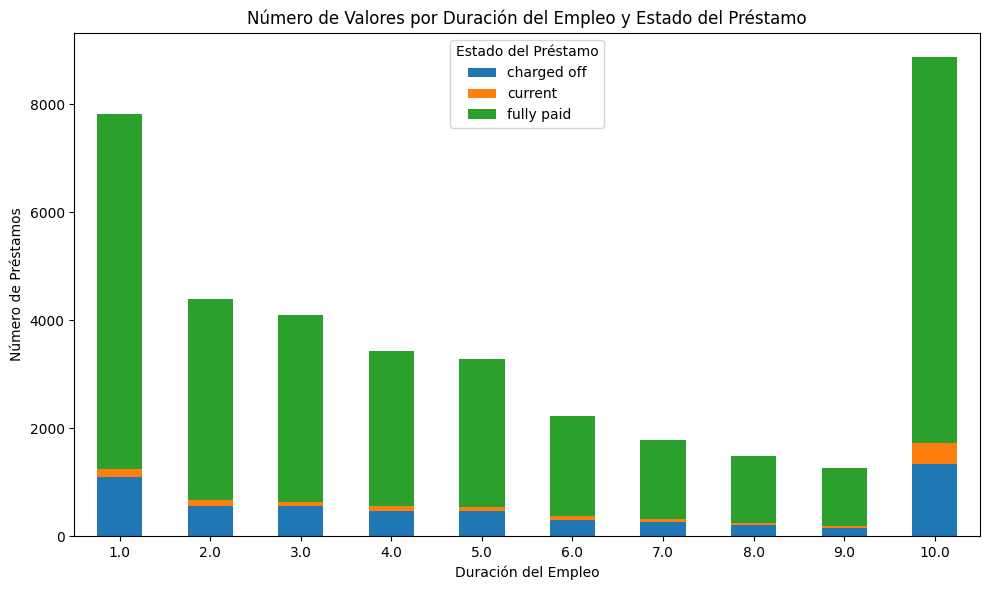

In [36]:
# Valores de 'employment_length' discriminando por 'loan_status'
pivot_df = df.pivot_table(index='employment_length', columns='loan_status', aggfunc='size', dropna=True)

# Crear el gráfico de barras apiladas
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configuración del gráfico
plt.xlabel('Duración del Empleo')
plt.ylabel('Número de Préstamos')
plt.title('Número de Valores por Duración del Empleo y Estado del Préstamo')
plt.legend(title='Estado del Préstamo')
plt.xticks(rotation=0)  # Rotar etiquetas del eje x si es necesario

# Mostrar el gráfico
plt.tight_layout()
plt.show()

En porcentajes por tipo sobre el total

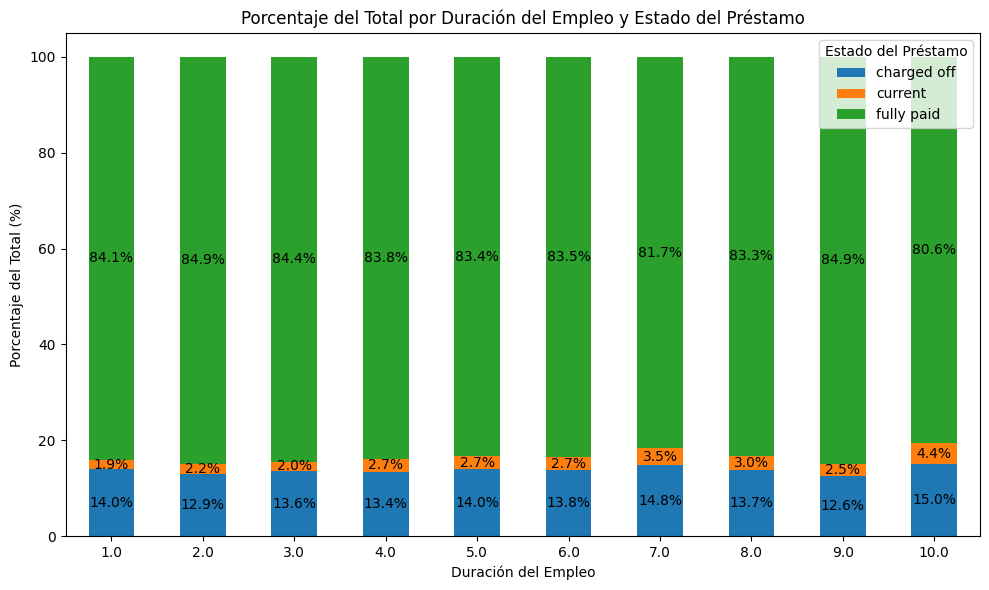

In [37]:
# Conteo de valores de 'employment_length' discriminando por 'loan_status'
pivot_df = df.pivot_table(index='employment_length', columns='loan_status', aggfunc='size', fill_value=0)

# Calcular los porcentajes
totals = pivot_df.sum(axis=1)
percentage_df = pivot_df.div(totals, axis=0) * 100

# Crear el gráfico de barras apiladas con porcentajes y etiquetas
ax = percentage_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configuración del gráfico
plt.xlabel('Duración del Empleo')
plt.ylabel('Porcentaje del Total (%)')
plt.title('Porcentaje del Total por Duración del Empleo y Estado del Préstamo')
plt.legend(title='Estado del Préstamo')
plt.xticks(rotation=0)  # Rotar etiquetas del eje x si es necesario

# Agregar etiquetas con los porcentajes a las barras
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{height:.1f}%', ha='center', va='center', color='black')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [38]:
pivot_df.to_csv('../src/data/process/pivot_df.csv', index=False)

In [39]:
percentage_df.to_csv('../src/data/process/percentage_df.csv', index=False)

Veamos ahora un dataset con los datos de 'employment_length' Nan, para ver si podemos establecer algún criterio para asignar estos valores.

In [40]:
df[df['employment_length'].isna()].head(10)

,id,loan_status,loan_amount,loan_term,interest_rate,installment,grade,verification_status,purpose,dti,inquiries,open_credit_lines,derogatory,revolving_rate,total_credit_lines,employment_length,home_ownership,annual_income
168,1067644,charged off,2500,36,7.51,77.78,a,source verified,debt_consolidation,16.30,2,13,0,42.2,20,NaN,own,12000.0
323,1058717,fully paid,18000,60,17.58,452.98,d,verified,debt_consolidation,21.96,1,11,0,83.7,28,NaN,mortgage,60000.0
394,1064582,fully paid,4000,36,11.71,132.31,b,source verified,home_improvement,7.50,0,4,0,54.9,6,NaN,rent,24000.0
422,1064366,charged off,1000,36,14.65,34.50,c,not verified,major_purchase,6.00,2,3,1,83.7,8,NaN,rent,18408.0
439,1063912,fully paid,8250,36,7.51,256.67,a,verified,debt_consolidation,17.87,4,17,0,10.4,37,NaN,mortgage,31500.0
534,1062897,charged off,1700,36,7.90,53.20,a,not verified,home_improvement,27.00,0,9,0,91.2,27,NaN,mortgage,37800.0
555,1062781,fully paid,5000,36,8.90,158.77,a,source verified,other,16.17,0,9,0,53.0,32,NaN,mortgage,70000.0
562,1062535,fully paid,3000,36,9.91,96.68,b,not verified,renewable_energy,4.29,0,3,0,33.3,3,NaN,mortgage,42000.0
569,1036838,charged off,8575,36,17.58,308.21,d,verified,debt_consolidation,22.54,1,4,0,89.9,5,NaN,mortgage,32000.0
678,1061194,fully paid,5600,36,6.03,170.44,a,not verified,car,3.97,0,17,0,2.7,44,NaN,own,41100.0


No parece haber un criterio claro para asignar los Nan de esta columna. Ya que representan un porcentaje pequeño de nuestro dataset, vamos a proceder a eliminarlos.

In [41]:
df.dropna(subset=['employment_length'], inplace=True)

### Búsqueda y sustitución de outliers

El siguiente paso es buscar posibles outliers o valores atípicos. Para detectar posibles valores atípicos usamos gráficos de tipo boxplot, en las variables que sean cuantitativas contínuas.

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38642 entries, 0 to 39716
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   38642 non-null  int64  
 1   loan_status          38642 non-null  object 
 2   loan_amount          38642 non-null  int64  
 3   loan_term            38642 non-null  int64  
 4   interest_rate        38642 non-null  float64
 5   installment          38642 non-null  float64
 6   grade                38642 non-null  object 
 7   verification_status  38642 non-null  object 
 8   purpose              38642 non-null  object 
 9   dti                  38642 non-null  float64
 10  inquiries            38642 non-null  int64  
 11  open_credit_lines    38642 non-null  int64  
 12  derogatory           38642 non-null  int64  
 13  revolving_rate       38642 non-null  float64
 14  total_credit_lines   38642 non-null  int64  
 15  employment_length    38642 non-null  floa

Vemos los valores únicos de cada columna

In [44]:
for columna in df.columns:
    num_valores_unicos = df[columna].nunique()
    print(f"La columna '{columna}' tiene {num_valores_unicos} valores únicos.")

La columna 'id' tiene 38642 valores únicos.
La columna 'loan_status' tiene 3 valores únicos.
La columna 'loan_amount' tiene 880 valores únicos.
La columna 'loan_term' tiene 2 valores únicos.
La columna 'interest_rate' tiene 371 valores únicos.
La columna 'installment' tiene 15149 valores únicos.
La columna 'grade' tiene 7 valores únicos.
La columna 'verification_status' tiene 3 valores únicos.
La columna 'purpose' tiene 14 valores únicos.
La columna 'dti' tiene 2863 valores únicos.
La columna 'inquiries' tiene 9 valores únicos.
La columna 'open_credit_lines' tiene 40 valores únicos.
La columna 'derogatory' tiene 5 valores únicos.
La columna 'revolving_rate' tiene 1087 valores únicos.
La columna 'total_credit_lines' tiene 82 valores únicos.
La columna 'employment_length' tiene 10 valores únicos.
La columna 'home_ownership' tiene 5 valores únicos.
La columna 'annual_income' tiene 5100 valores únicos.


In [50]:
columnas_continuas = []

for columna in df.columns:
    if df[columna].nunique() > 100:
        columnas_continuas.append(columna)

        

In [51]:
columnas_continuas.remove('id')
columnas_continuas

['loan_amount',
 'interest_rate',
 'installment',
 'dti',
 'revolving_rate',
 'annual_income']

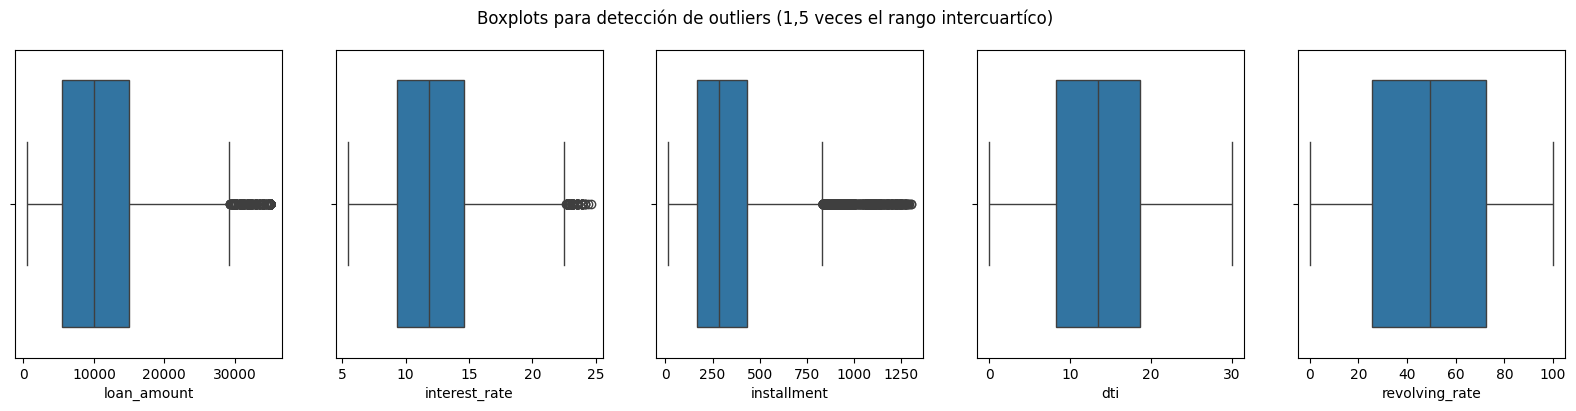

In [52]:
# Crear boxplots para cada columna continua
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Boxplots para detección de outliers (1,5 veces el rango intercuartíco)')
sns.boxplot(ax=axes[0], x=df[columnas_continuas[0]])
sns.boxplot(ax=axes[1], x=df[columnas_continuas[1]])
sns.boxplot(ax=axes[2], x=df[columnas_continuas[2]])
sns.boxplot(ax=axes[3], x=df[columnas_continuas[3]])
sns.boxplot(ax=axes[4], x=df[columnas_continuas[4]])
plt.show();

Por la gráfica, vemos que tanto las columnas 'dti' o 'revolving_rate' no tiene outliers apreciables. Las otras 3 columnas, y sobre todo la columna 'annual_income' parecen tener elevados valores fuera del rango del 1,5 * rango intercuartílico

In [53]:
df[columnas_continuas].describe().round(2)

,loan_amount,interest_rate,installment,dti,revolving_rate,annual_income
count,38642.00,38642.00,38642.00,38642.00,38642.00,38642.00
mean,11291.62,12.05,326.76,13.33,48.94,69608.28
std,7462.14,3.72,209.14,6.67,28.34,64253.20
min,500.00,5.42,15.69,0.00,0.00,4000.00
25%,5500.00,9.32,168.44,8.20,25.50,41400.00
50%,10000.00,11.86,282.83,13.42,49.50,60000.00
75%,15000.00,14.59,434.40,18.59,72.50,83199.99
max,35000.00,24.59,1305.19,29.99,99.90,6000000.00


Vamos a volver a realizar un gráfico boxplot para las columnas 'loan_amount', 'interest_rate' y 'annual_income', pero tomando con outliers la cantidad de 6 veces el rango intercuartílico, a fin de disminuir la cantidad de valores que dejamos fuera como consecuencia de tomar el 1,5 * rango intercuartílico

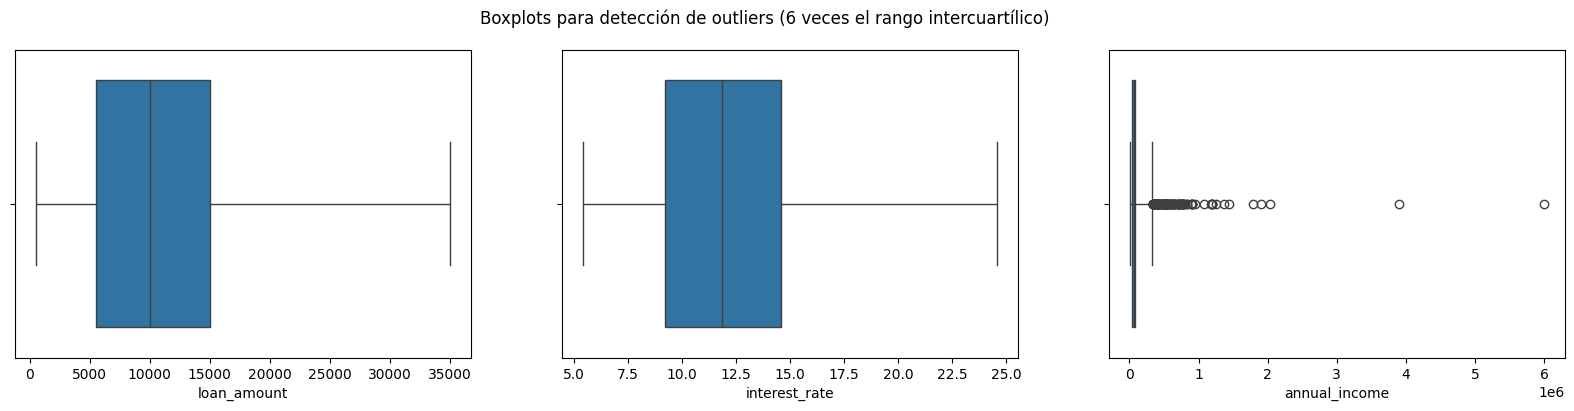

In [46]:
# Filtrar las columnas que contienen variables numéricas continuas
columnas_continuas_2 = ['loan_amount', 'interest_rate', 'annual_income']

# Crear boxplots para cada columna continua
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Boxplots para detección de outliers (6 veces el rango intercuartílico)')
sns.boxplot(ax=axes[0], x=df_final[columnas_continuas_2[0]], whis=6)
sns.boxplot(ax=axes[1], x=df_final[columnas_continuas_2[1]], whis=6)
sns.boxplot(ax=axes[2], x=df_final[columnas_continuas_2[2]], whis=6)

plt.show();

Aumentando a 6 las veces del rango intercuartílico para considerar un valor como outlier resolvemos la existencia de outliers en las columnas 'loan_amount' y 'interest_rate', pero seguimos teniendo muchos valores como outliers en la columna 'annual_income'. Vamos a estudiar con detenimiento cuántos valores son y de qué importes estamos hablando en esta columna.

In [47]:
q1_income = df_final['annual_income'].quantile(0.25)
q3_income = df_final['annual_income'].quantile(0.75)
iqr_income = q3_income - q1_income
upper_income = q3_income + 6 * iqr_income
lower_income = q1_income - 6 * iqr_income

In [48]:
df_final[df_final['annual_income'] > upper_income]['annual_income'].describe().round(2)

count        144.00
mean      649266.30
std       609564.42
min       334000.00
25%       374250.00
50%       493500.00
75%       711000.00
max      6000000.00
Name: annual_income, dtype: float64

Vemos que los valores que superan las 6 veces el rango intercuartílico de la columna 'annual_income' son 144 valores de 39.717 (0,36 %). El importe mínimo de este grupo es de
334.000, y el máximo es de 6.000.000. 
Vamos a optar por asignar a todos los valores de la columna 'annual_income" que superen los 334.000 este valor.

In [49]:
iqr_factor = 6
q1 = df_final['annual_income'].quantile(0.25)
q3 = df_final['annual_income'].quantile(0.75)
iqr = q3 - q1
upper_threshold = q3 + (iqr_factor * iqr)
print('ingreso anual')
print('q3:', q3)
print('umbral superior:', upper_threshold)

# Reasignar valores 
df_final.loc[df_final['annual_income'] > upper_threshold, 'annual_income'] = upper_threshold
print(df_final['annual_income'].describe().round(2))

ingreso anual
q3: 82300.0
umbral superior: 333676.0
count     39717.00
mean      67824.71
std       41995.03
min        4000.00
25%       40404.00
50%       59000.00
75%       82300.00
max      333676.00
Name: annual_income, dtype: float64


Volvemos a hacer el gráfico de boxplots inicial, pero con un factor 6 por el rango intercuartílico

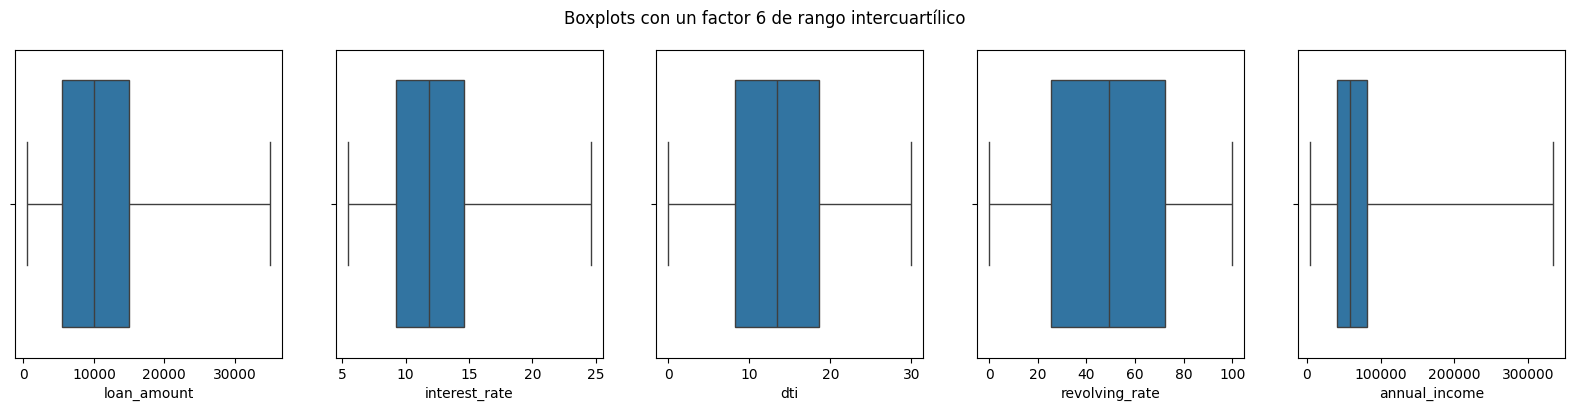

In [50]:
# Filtrar las columnas que contienen variables numéricas continuas
columnas_continuas = ['loan_amount', 'interest_rate', 'dti', 'revolving_rate', 'annual_income']

# Crear boxplots para cada columna continua
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Boxplots con un factor 6 de rango intercuartílico')
sns.boxplot(ax=axes[0], x=df_final[columnas_continuas[0]], whis=6)
sns.boxplot(ax=axes[1], x=df_final[columnas_continuas[1]], whis=6)
sns.boxplot(ax=axes[2], x=df_final[columnas_continuas[2]], whis=6)
sns.boxplot(ax=axes[3], x=df_final[columnas_continuas[3]], whis=6)
sns.boxplot(ax=axes[4], x=df_final[columnas_continuas[4]], whis=6)

plt.show();

Vemos que ahora ya no tenemos outliers

In [51]:
df_final_clean = df_final.copy()
df_final_clean.to_csv('../src/data/process/df_final_clean.csv', index=False)

Una vez que tenemos el dataset limpio, vamos a proceder a dividirlo en 2 distinguiendo entre si crédito está todavía en vigor "current" o no
* df_final_current: comprende el dataframe limpio pero con solo con los créditos pagadosen vigor
* df_final_no_current: dataframe limpio con todos los créditos ya vencidos


In [52]:
df_final_current = df_final[df_final['loan_status'] == 'current']
df_final_current.to_csv('../src/data/process/df_final_current.csv', index=False)

df_final_due = df_final[df_final['loan_status'] != 'current']
df_final_due.to_csv('../src/data/process/df_final_due.csv', index=False)

A la vez los créditos vencidos, vamos a dividirlos entre:

* df_final_paid: dataset con créditos pagados
* df_final_charged_off: dataset con créditos impagados

In [53]:
df_final = df_final_due
df_final_paid = df_final[df_final['loan_status'] == 'fully paid']
df_final_charged_off = df_final[df_final['loan_status'] == 'charged off']

df_final_paid.to_csv('../src/data/process/df_final_paid.csv', index=False)
df_final_charged_off.to_csv('../src/data/process/df_final_charged_off.csv', index=False)
df_final.to_csv('../src/data/final/df_final.csv', index=False)

In [54]:
df_final.head()

,id,loan_status,loan_amount,loan_term,interest_rate,installment,purpose,dti,revolving_rate,employment_length,home_ownership,annual_income
0,1077501,fully paid,5000,36,10.65,162.87,credit_card,27.65,83.7,10,rent,24000.0
1,1077430,charged off,2500,60,15.27,59.83,car,1.00,9.4,1,rent,30000.0
2,1077175,fully paid,2400,36,15.96,84.33,small_business,8.72,98.5,10,rent,12252.0
3,1076863,fully paid,10000,36,13.49,339.31,other,20.00,21.0,10,rent,49200.0
5,1075269,fully paid,5000,36,7.90,156.46,wedding,11.20,28.3,3,rent,36000.0


## Análisis

Veamos primero un gráfico pairplot con las principales columnas del dataframe

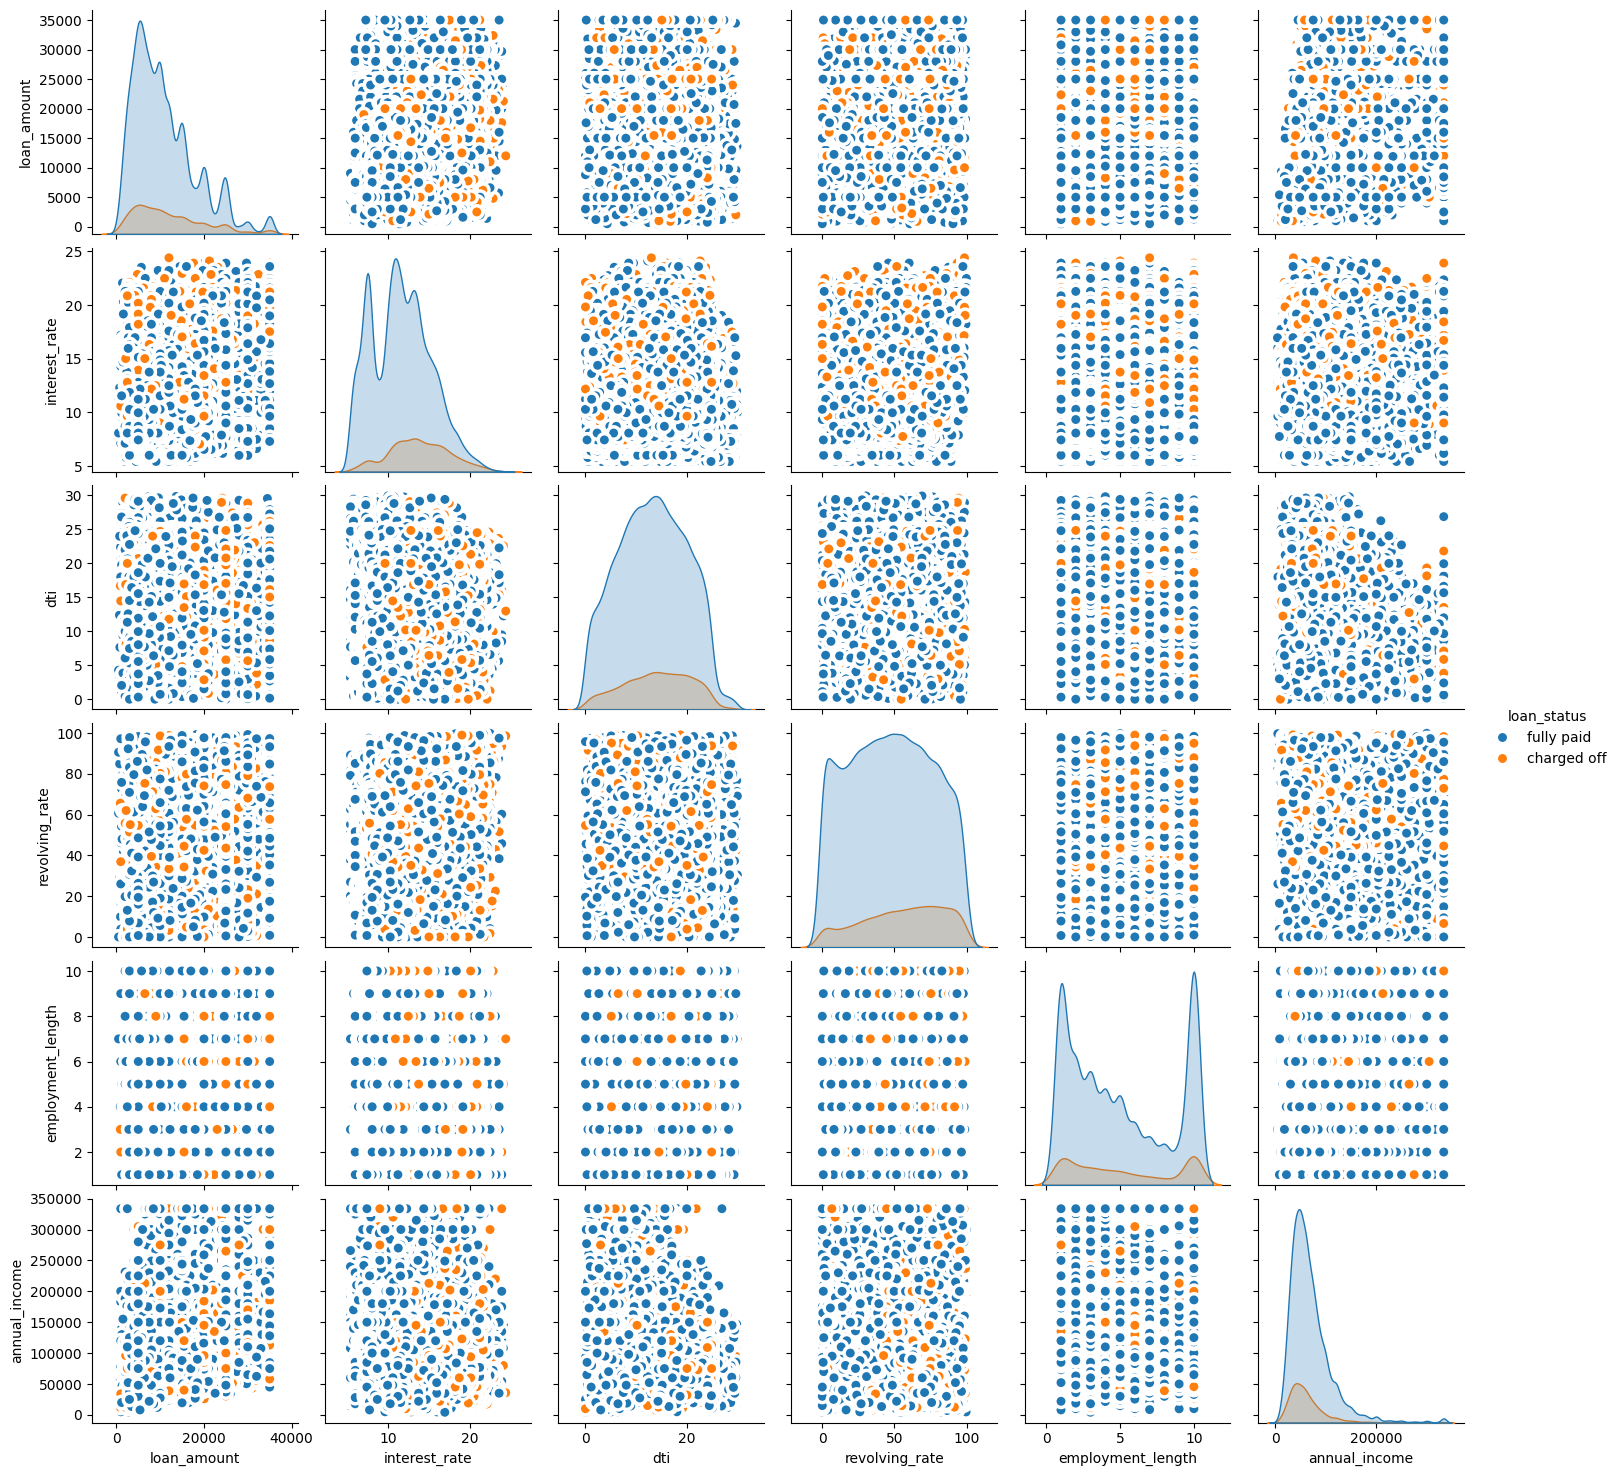

In [55]:
columnas_pairplot = ['loan_status', 'loan_amount', 'interest_rate', 'purpose', 
                     'dti', 'revolving_rate', 'employment_length', 'home_ownership', 'annual_income']

sns.pairplot(df_final[columnas_pairplot], kind='scatter', hue='loan_status',
             plot_kws=dict(s=80, edgecolor='white',linewidth=2.5));

De una primera visualización de la relación entre las diferentes variables de nuestro dataframe no parecen inferirse relaciones claras entre las variables, más allá de que algunas 
distribuciones pudieran ser normales.

### Análisis Univariante y Bivariante

Veamos primero un histograma de la variable 'loan_amount', diferenciando gráficamente entre si el préstamo ha sido pagado o no

También vemos un mapa de calor con el porcentaje de impagados por tramos

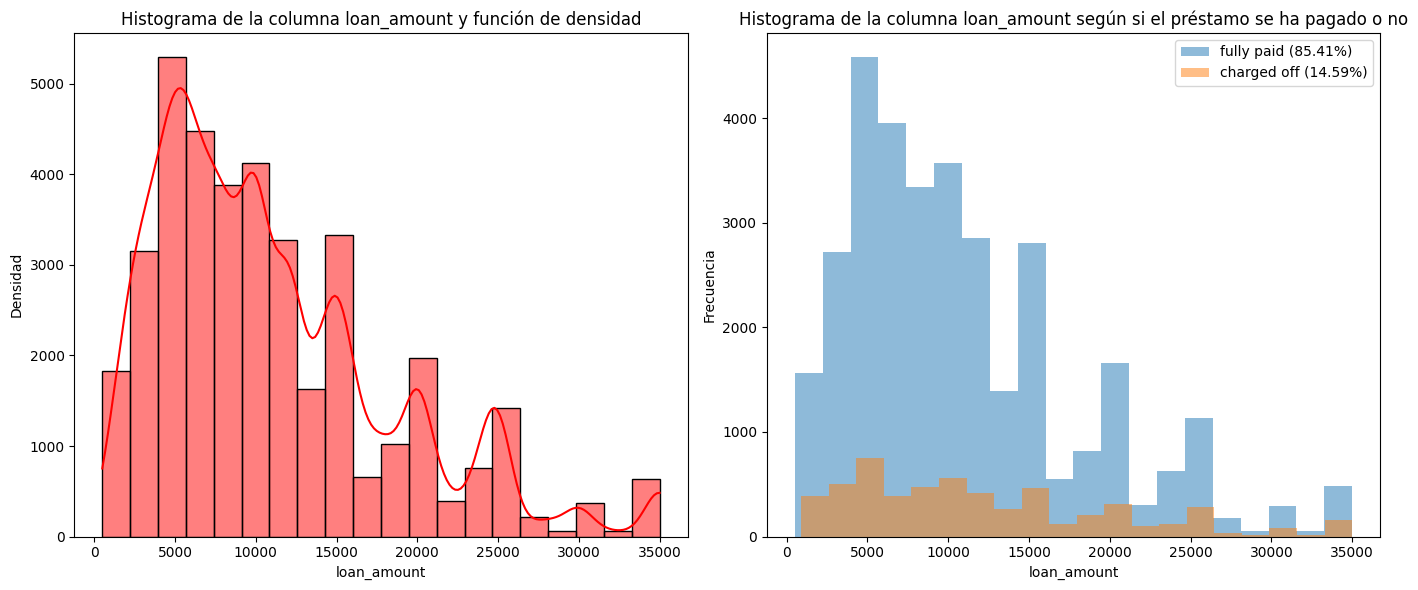

In [56]:
graficos_var_cont(df_final, 'loan_amount', 'red')

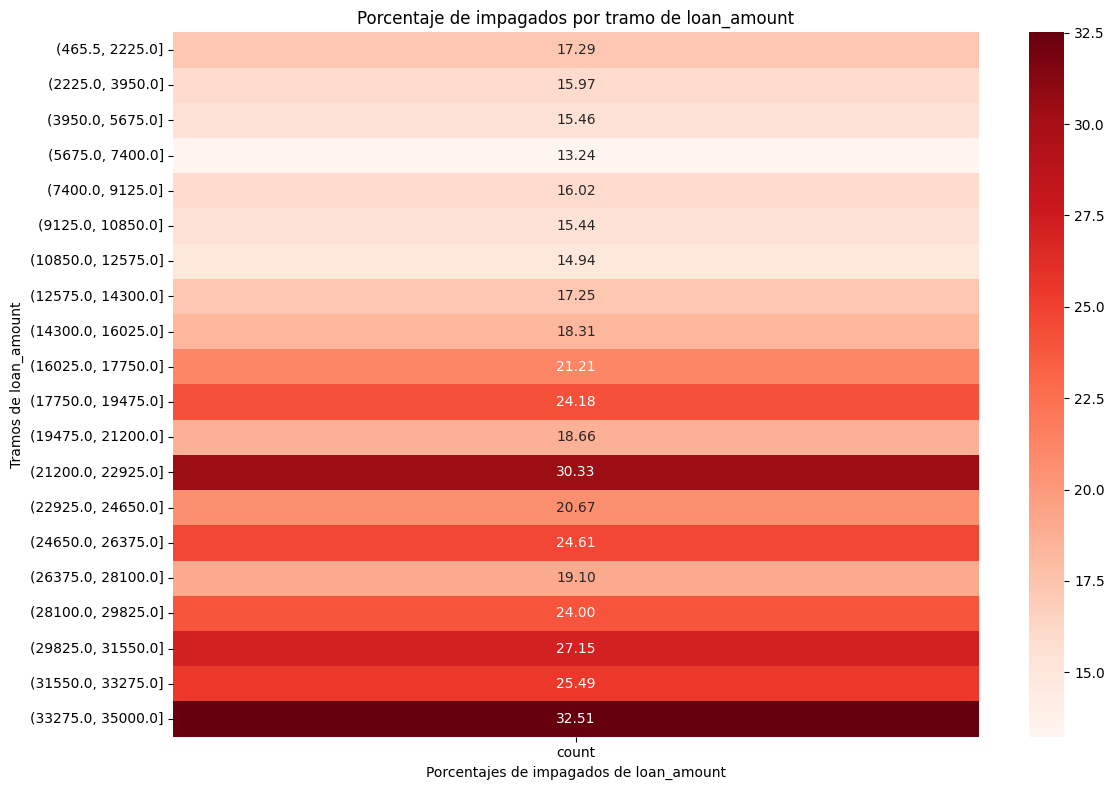

In [57]:
mapa_calor_impagados_cont(df_final, 'loan_amount', 'Reds')

Veamos ahora un histograma de la variable 'interest_rate', diferenciando gráficamente entre si el préstamo ha sido pagado o no.

También vemos un mapa de calor con el porcentaje de impagados por tramos

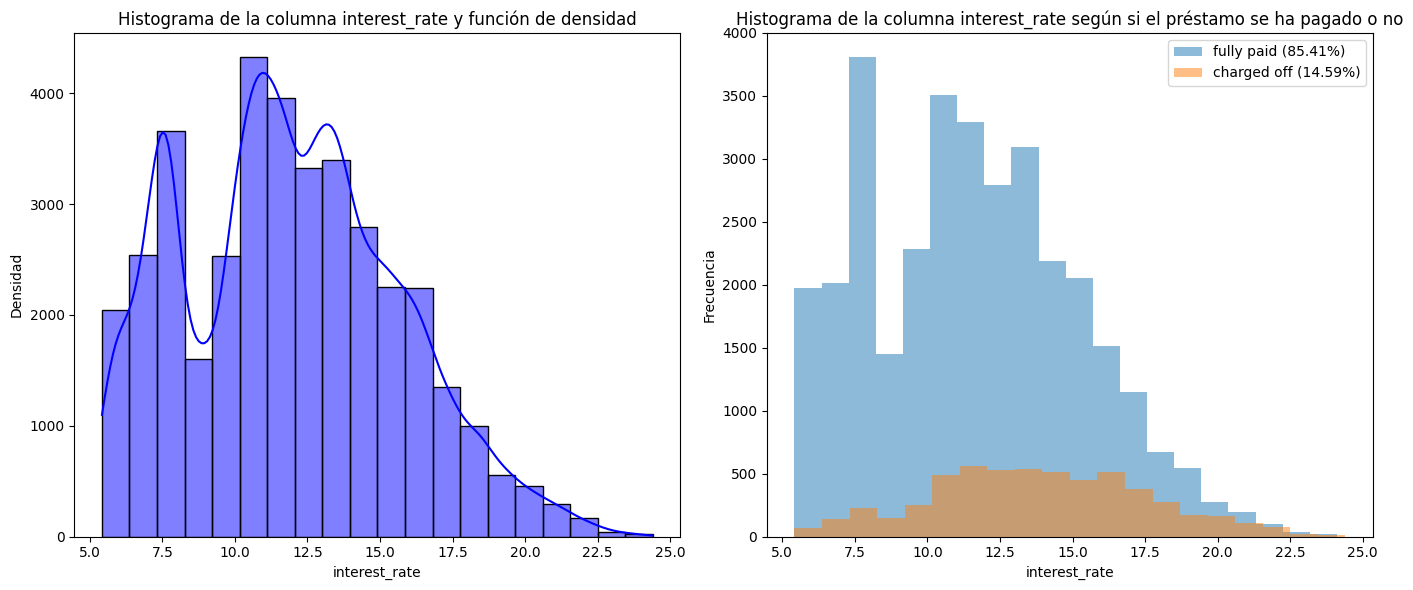

In [58]:
graficos_var_cont(df_final, 'interest_rate', 'blue')

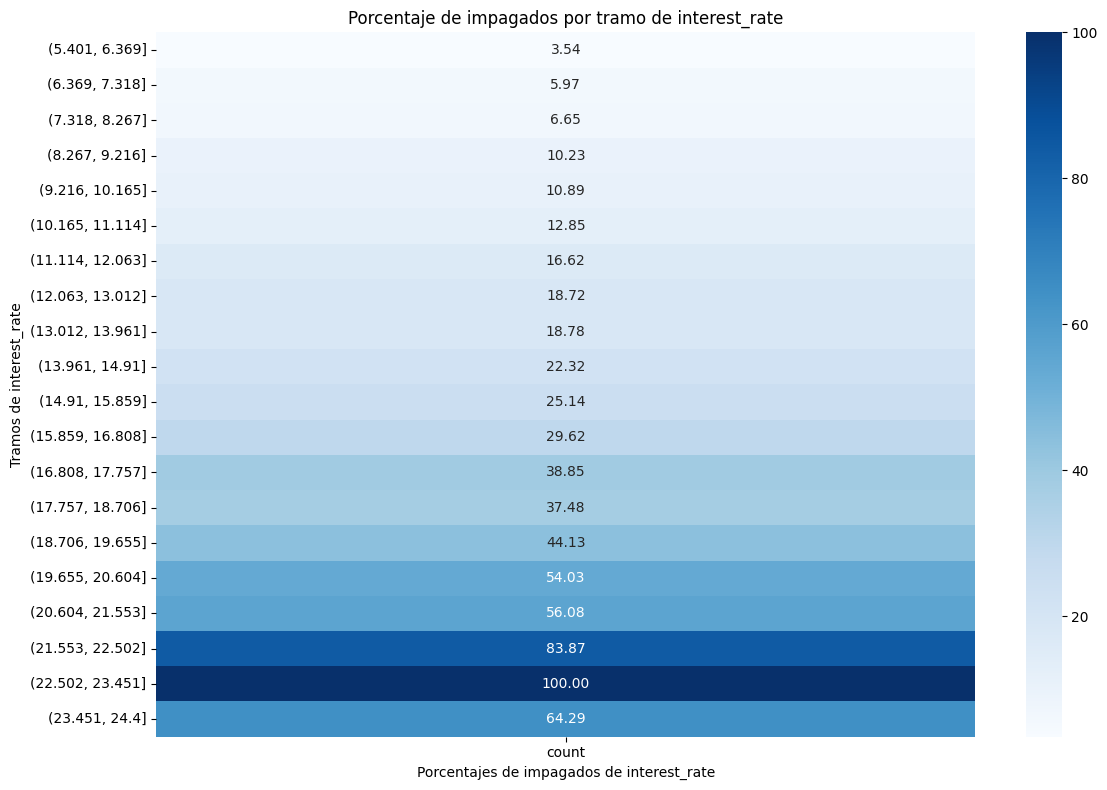

In [59]:
mapa_calor_impagados_cont(df_final, 'interest_rate', 'Blues')

Veamos ahora un histograma de la variable 'installment', diferenciando gráficamente entre si el préstamo ha sido pagado o no.

También vemos un mapa de calor con el porcentaje de impagados por tramos

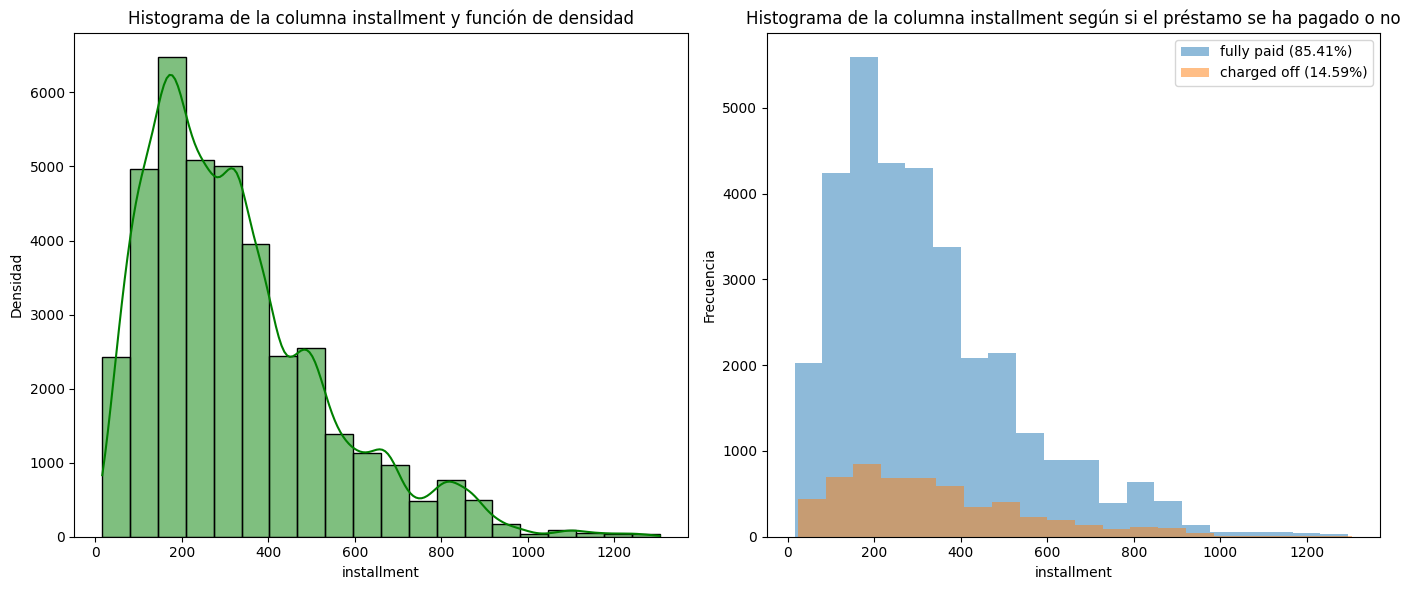

In [60]:
graficos_var_cont(df_final, 'installment', 'green')

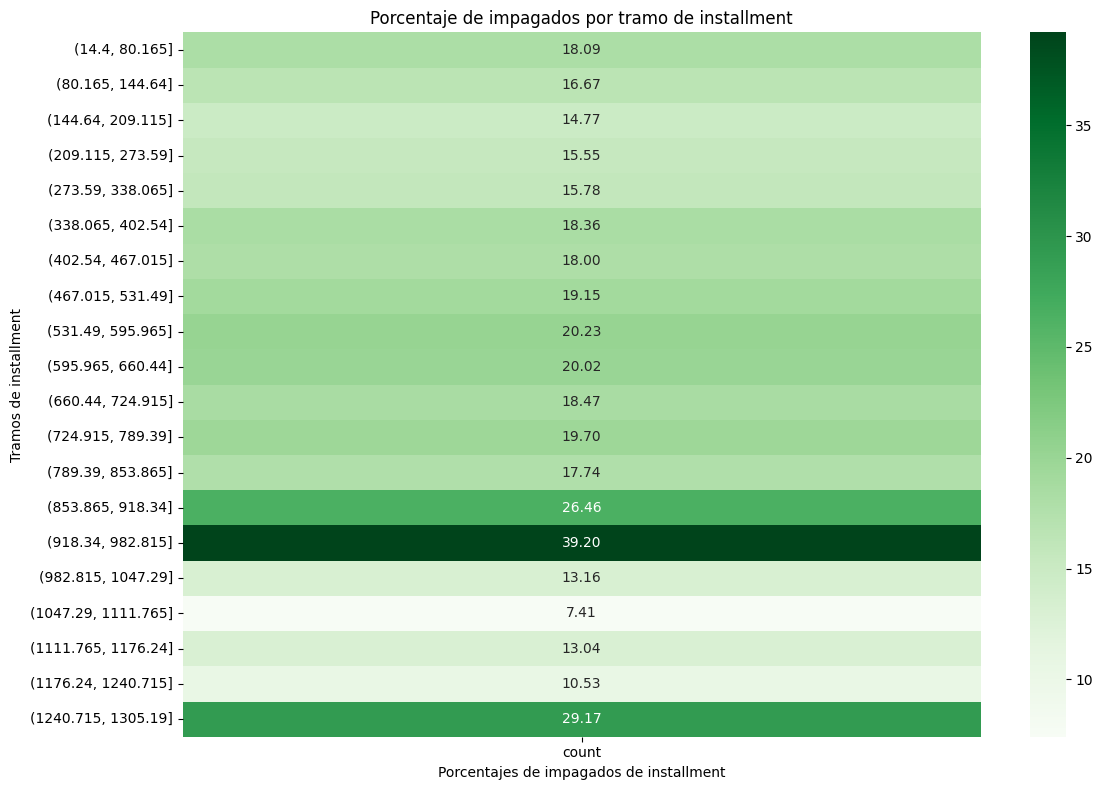

In [61]:
mapa_calor_impagados_cont(df_final, 'installment', 'Greens')

Veamos ahora un histograma de la variable 'dti', diferenciando gráficamente entre si el préstamo ha sido pagado o no.

También vemos un mapa de calor con el porcentaje de impagados por tramos

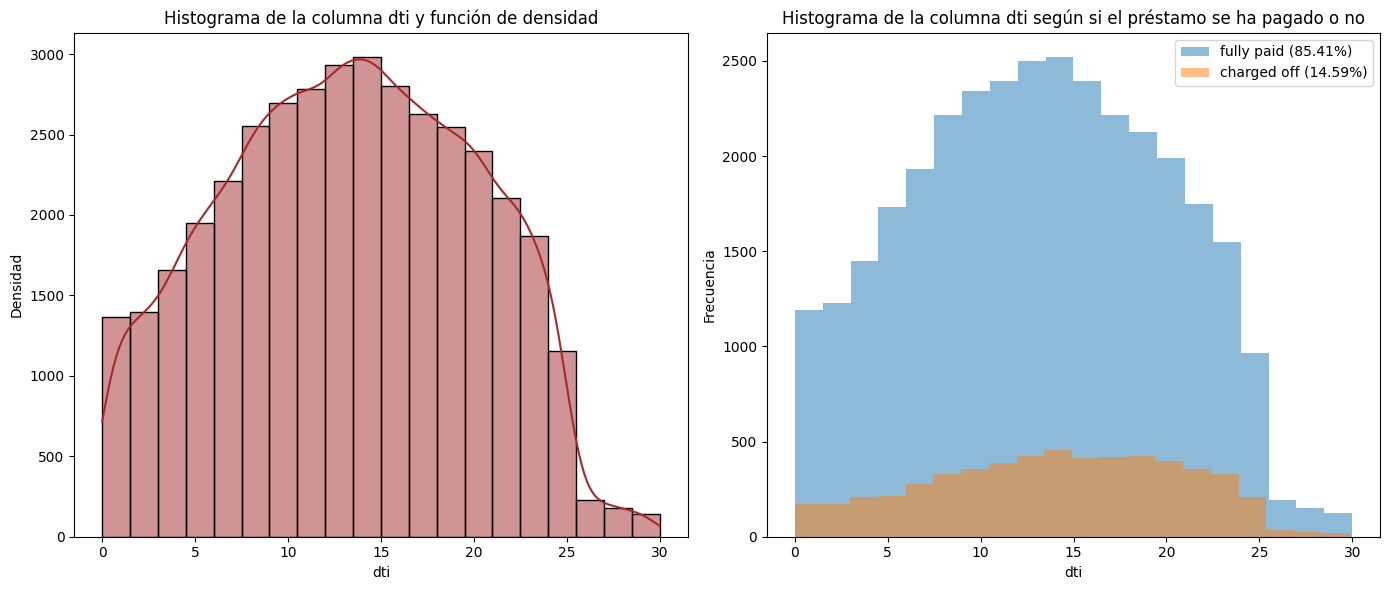

In [62]:
graficos_var_cont(df_final, 'dti', 'brown')

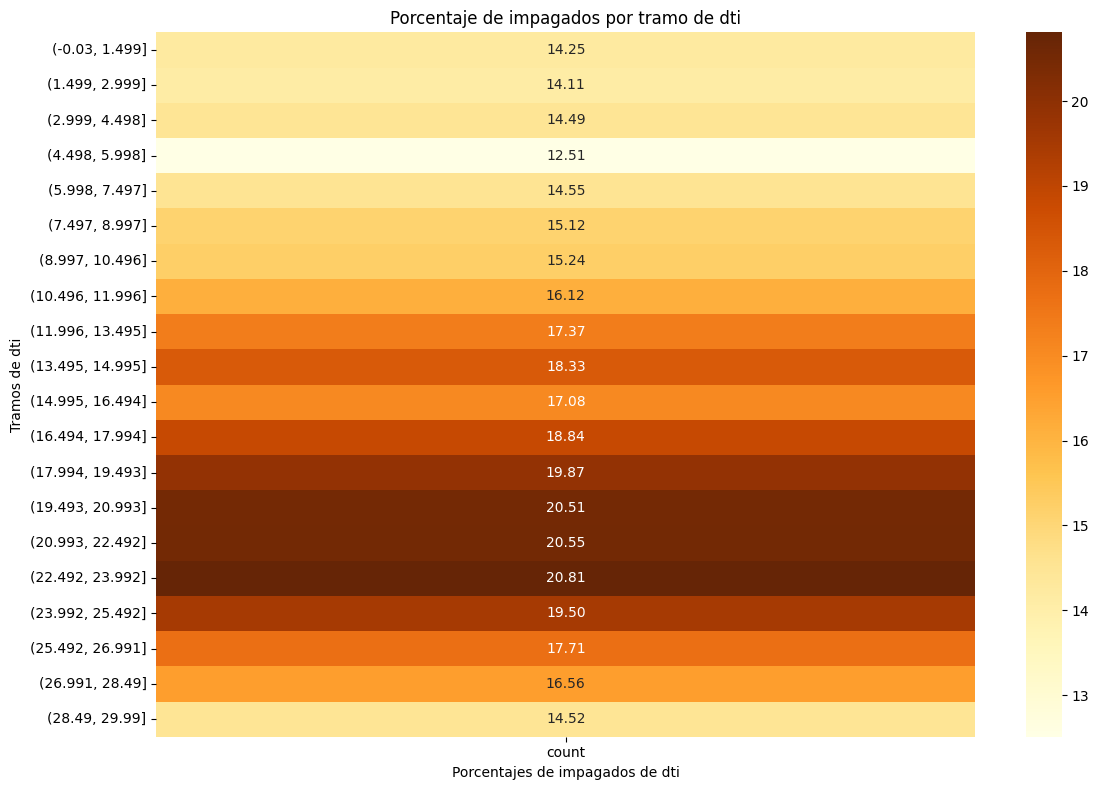

In [63]:
mapa_calor_impagados_cont(df_final, 'dti', 'YlOrBr')

Veamos ahora un histograma de la variable 'revolving_rate', diferenciando gráficamente entre si el préstamo ha sido pagado o no.

También vemos un mapa de calor con el porcentaje de impagados por tramos

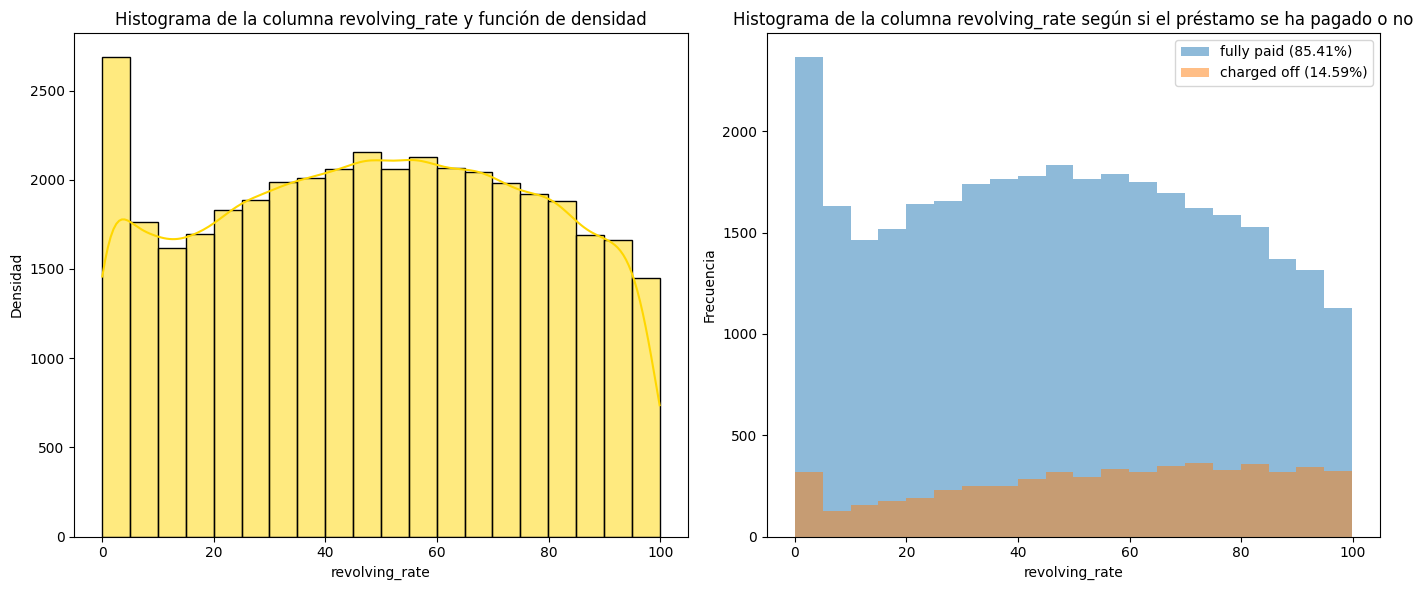

In [64]:
graficos_var_cont(df_final, 'revolving_rate', 'gold')

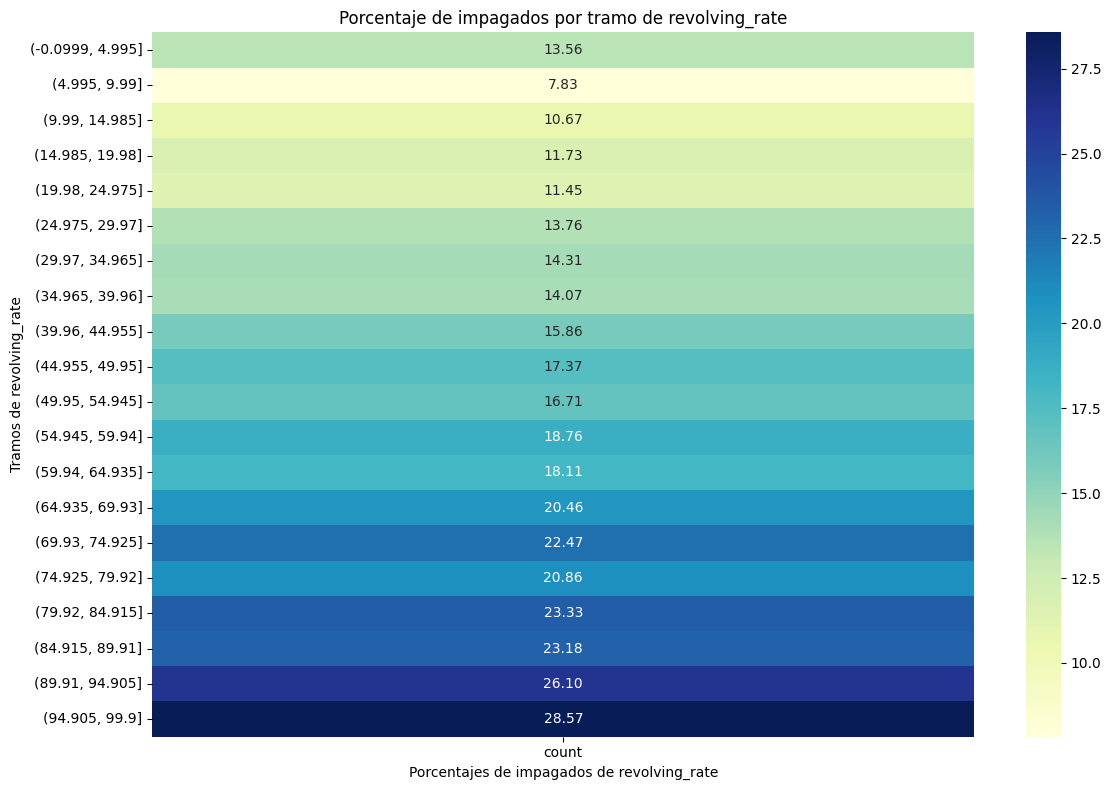

In [65]:
mapa_calor_impagados_cont(df_final, 'revolving_rate', 'YlGnBu')

Veamos ahora un histograma de la variable 'annual_income', diferenciando gráficamente entre si el préstamo ha sido pagado o no.

También vemos un mapa de calor con el porcentaje de impagados por tramos

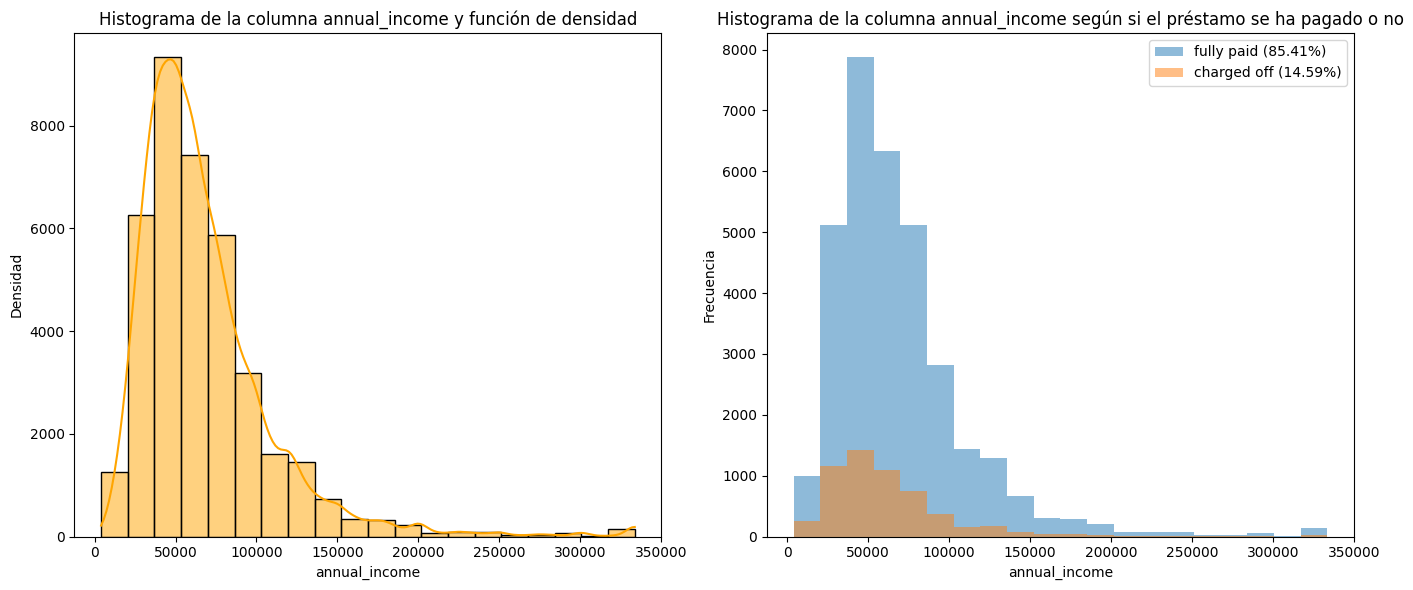

In [66]:
graficos_var_cont(df_final, 'annual_income', 'orange')

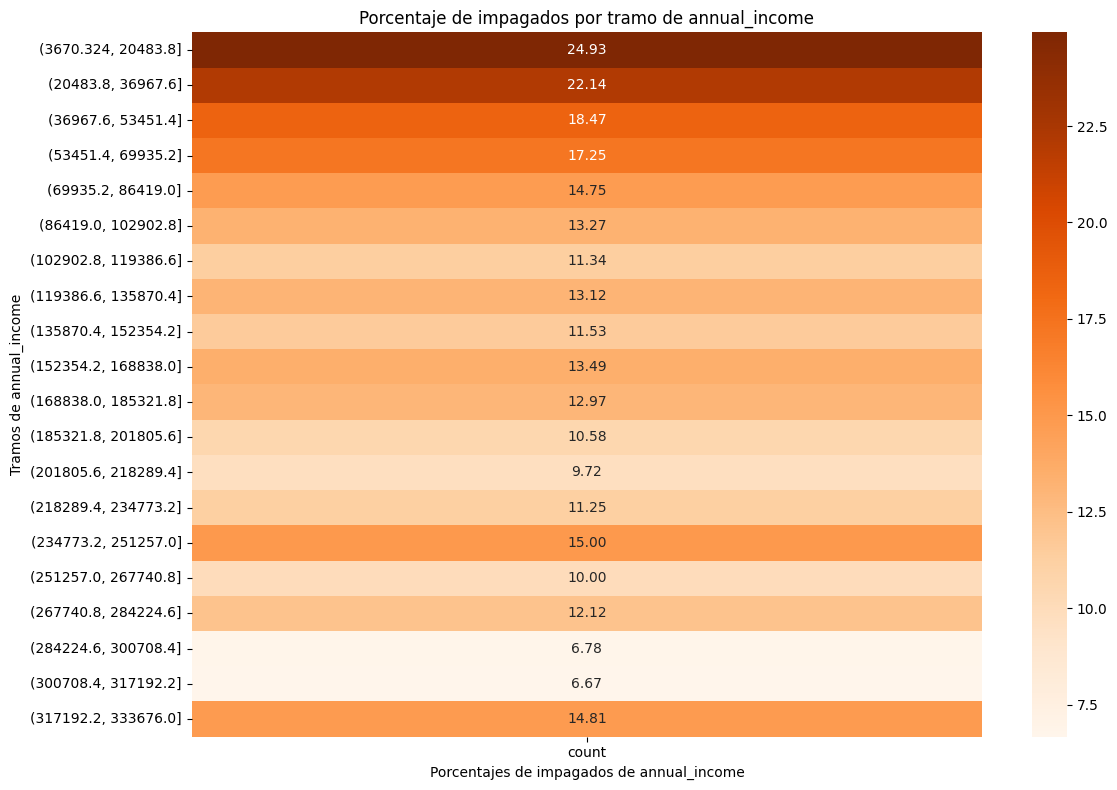

In [67]:
mapa_calor_impagados_cont(df_final, 'annual_income', 'Oranges')

Veamos ahora el gráfico de barras para la columna 'loan_term', diferenciando si el préstamo ha sido pagado o no, Luego una tabla con sus porcentajes relativos diferenciando según este mismo criterio y un mapa de calor con las categorías según el porcentaje relativo de impagados.

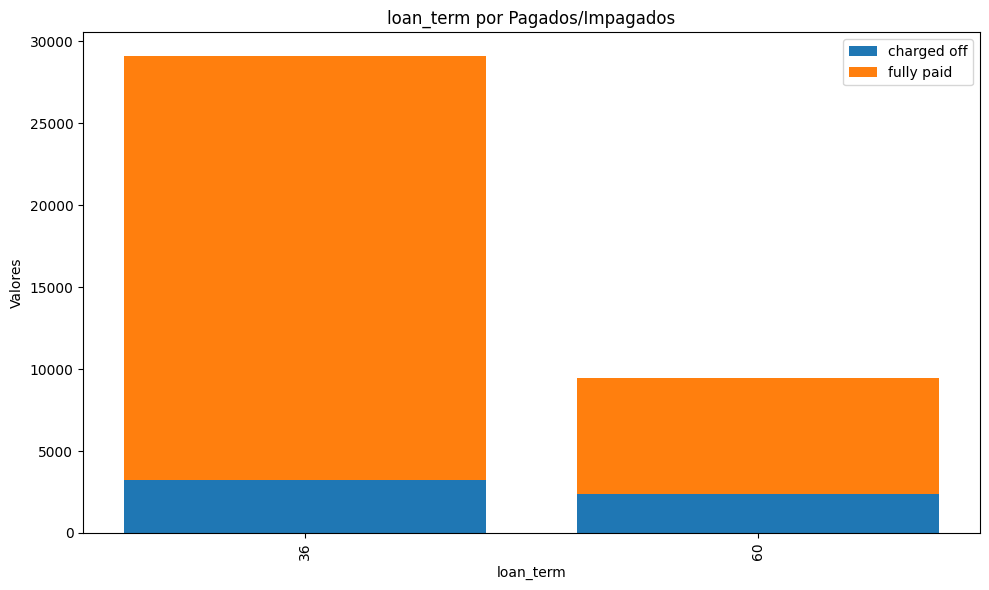

In [68]:
grafico_barras_loan_status(df=df_final, column_df='loan_term')

In [69]:
porcentaje_var_cat_status(df_final, 'loan_term')

loan_term,36,60
loan_status,,
charged off,57.348498,42.651502
fully paid,78.509863,21.490137


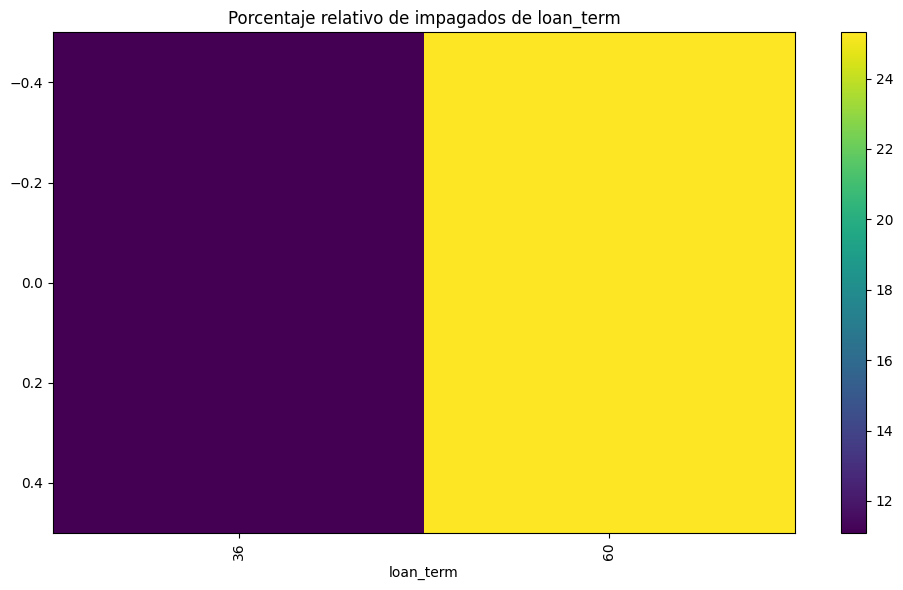

In [70]:
grafico_mapa_calor_impagados(df_final, 'loan_term', 'viridis')

Veamos ahora el gráfico de barras para la columna 'purpose', diferenciando si el préstamo ha sido pagado o no, Luego una tabla con sus porcentajes relativos diferenciando según este mismo criterio y un mapa de calor con las categorías según el porcentaje relativo de impagados.

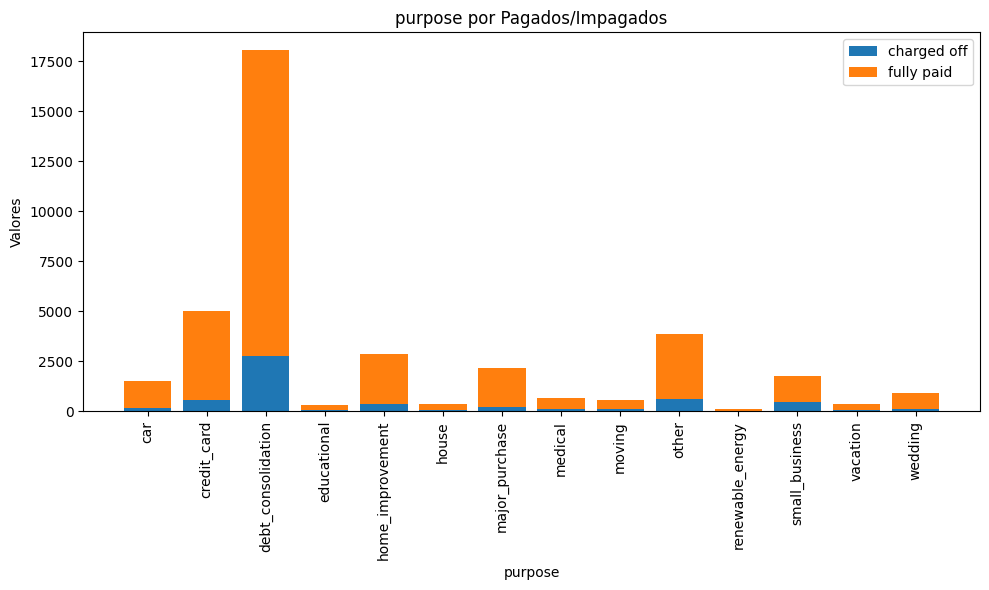

In [71]:
grafico_barras_loan_status(df_final, 'purpose')

In [72]:
porcentaje_var_cat_status(df_final, 'purpose')

purpose,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
loan_status,,,,,,,,,,,,,,
charged off,2.843433,9.632131,49.173627,0.995202,6.166696,1.048516,3.945264,1.883775,1.634974,11.249334,0.337658,8.441443,0.941887,1.706060
fully paid,4.063733,13.611533,46.397572,0.816388,7.672231,0.934750,5.851290,1.745068,1.468892,9.808801,0.251897,3.881639,0.977238,2.518968


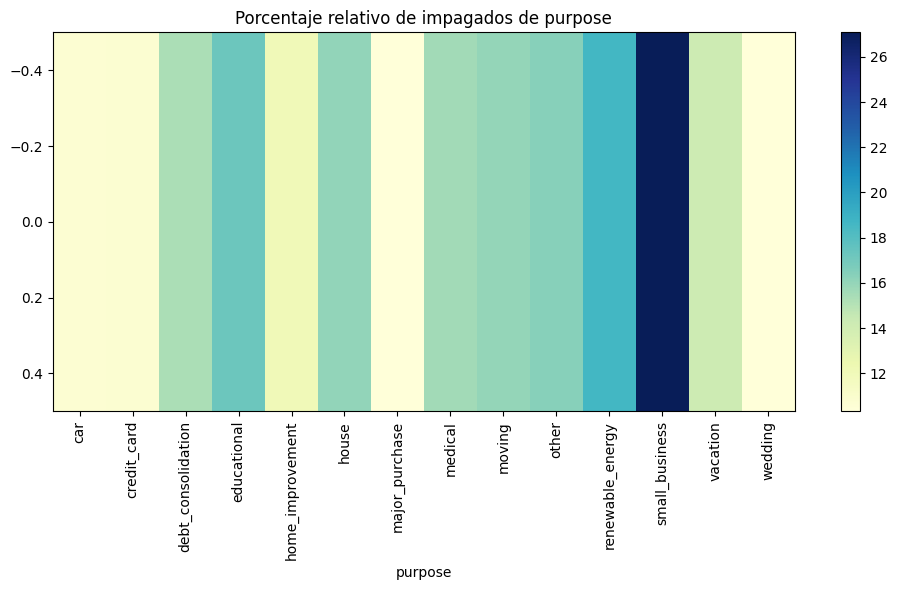

In [73]:
grafico_mapa_calor_impagados(df_final, 'purpose', 'YlGnBu')

Veamos ahora el gráfico de barras para la columna 'employment_length', diferenciando si el préstamo ha sido pagado o no, Luego una tabla con sus porcentajes relativos diferenciando según este mismo criterio y un mapa de calor con las categorías según el porcentaje relativo de impagados.

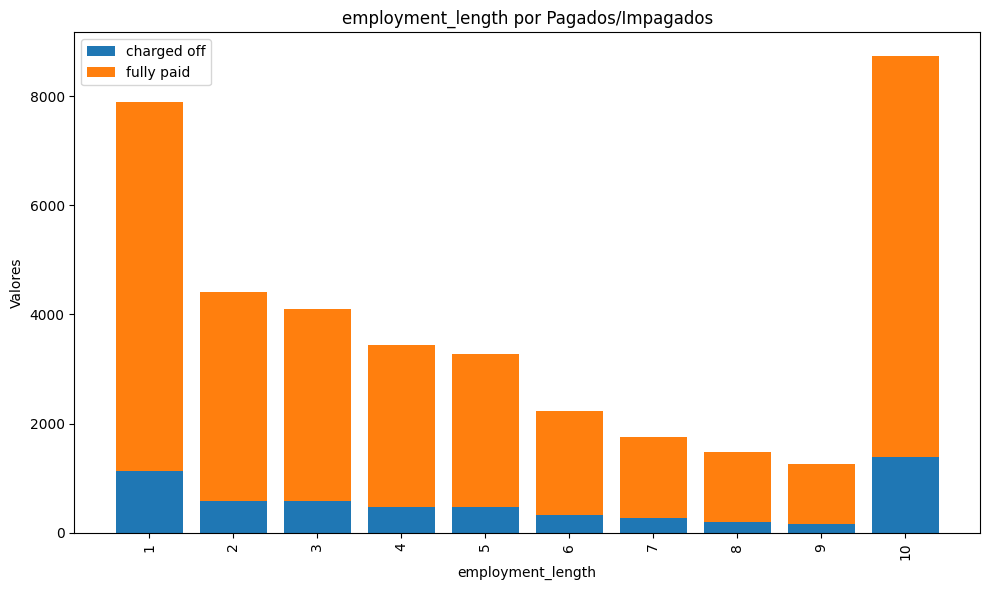

In [74]:
grafico_barras_loan_status(df_final, 'employment_length')

In [75]:
porcentaje_var_cat_status(df_final, 'employment_length')

employment_length,1,2,3,4,5,6,7,8,9,10
loan_status,,,,,,,,,,
charged off,20.206149,10.520704,10.342989,8.583615,8.370357,5.722410,4.887151,3.714235,2.967834,24.684557
fully paid,20.476480,11.614568,10.701062,8.962064,8.503794,5.796662,4.512898,3.851290,3.301973,22.279211


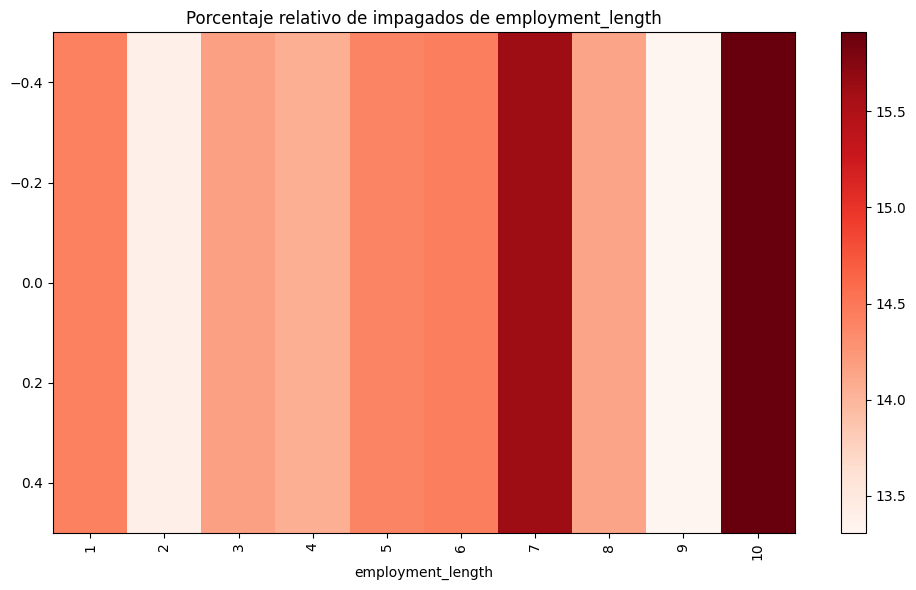

In [76]:
grafico_mapa_calor_impagados(df_final, 'employment_length', 'Reds')

Veamos ahora el gráfico de barras para la columna 'home_ownership', diferenciando si el préstamo ha sido pagado o no, Luego una tabla con sus porcentajes relativos diferenciando según este mismo criterio y un mapa de calor con las categorías según el porcentaje relativo de impagados.

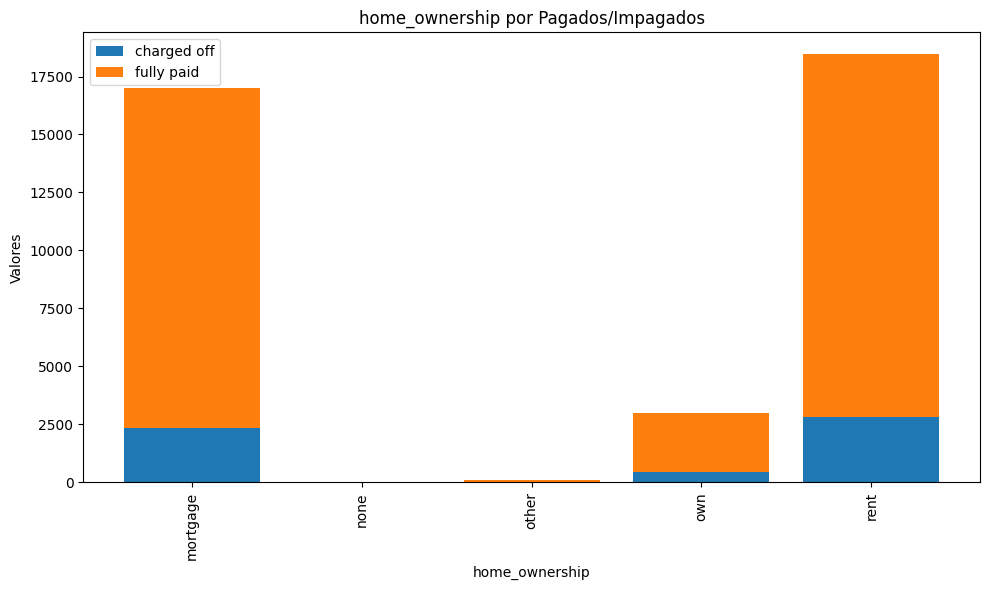

In [77]:
grafico_barras_loan_status(df_final, 'home_ownership')

In [78]:
porcentaje_var_cat_status(df_final, 'home_ownership')

home_ownership,mortgage,none,other,own,rent
loan_status,,,,,
charged off,41.354185,NaN,0.319886,7.872756,50.453172
fully paid,44.594841,0.009105,0.242792,7.684370,47.468892


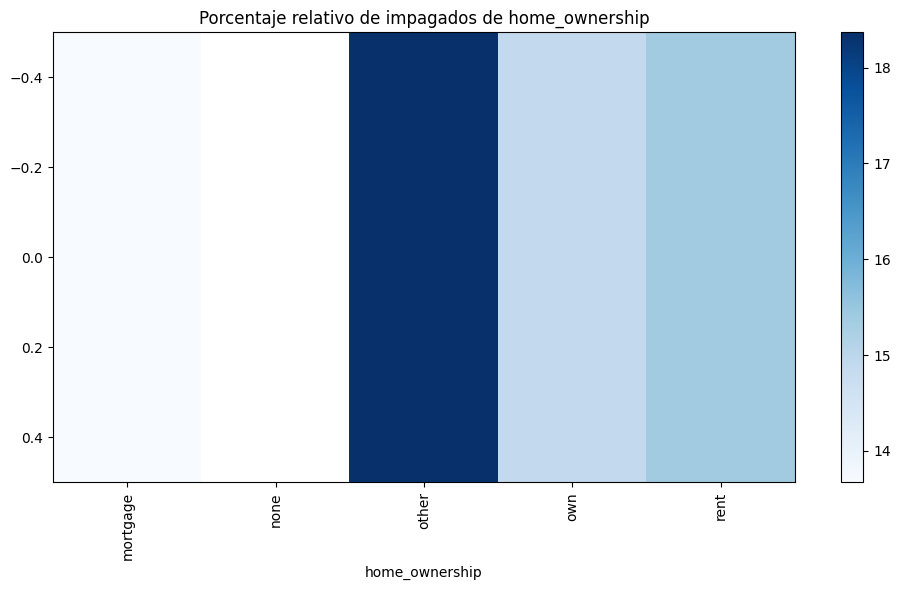

In [79]:
grafico_mapa_calor_impagados(df_final, 'home_ownership', 'Blues')

## Análisis Multivariante

Veamos en primer lugar la correlación existente entre las variables numéricas de nuestro dataset

In [80]:
columnas_estudio = [    
    'loan_amount',
    'interest_rate',
    'installment',
    'revolving_rate',
    'annual_income',
    'dti']

correlation_matrix = df_final[columnas_estudio].corr()
correlation_matrix

,loan_amount,interest_rate,installment,revolving_rate,annual_income,dti
loan_amount,1.000000,0.301265,0.932260,0.065247,0.401935,0.062436
interest_rate,0.301265,1.000000,0.277203,0.463627,0.076377,0.110913
installment,0.932260,0.277203,1.000000,0.094559,0.402437,0.052038
revolving_rate,0.065247,0.463627,0.094559,1.000000,0.035035,0.279091
annual_income,0.401935,0.076377,0.402437,0.035035,1.000000,-0.140882
dti,0.062436,0.110913,0.052038,0.279091,-0.140882,1.000000


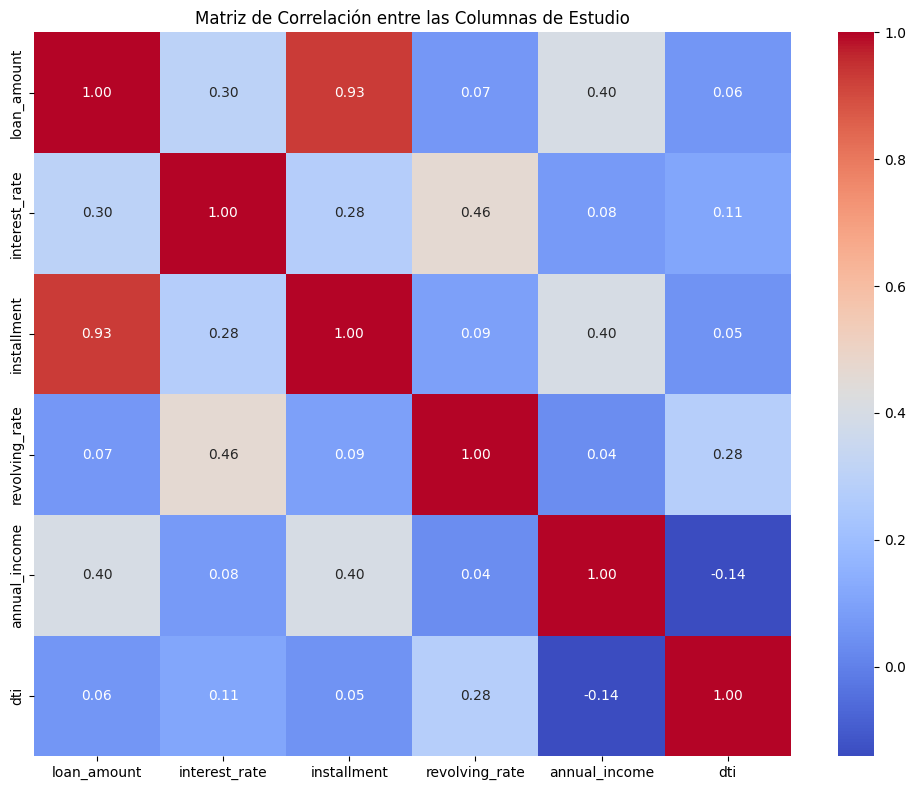

In [81]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación entre las Columnas de Estudio')
plt.tight_layout()
plt.show()

Como vemos la correlación entre las variables numéricas es muy baja, con la excepción de la correlación entre el importe del préstamo y la cuota pagada (lo cual tiene todo el sentido).

Cabe mencionar alguna relación entre el tipo de interés y la tasa de revolving, entre los ingresos anuales y la cuota pagada, y entre los ingresos anuales y el importe del préstamo

Vemos gráficamente estas relaciones

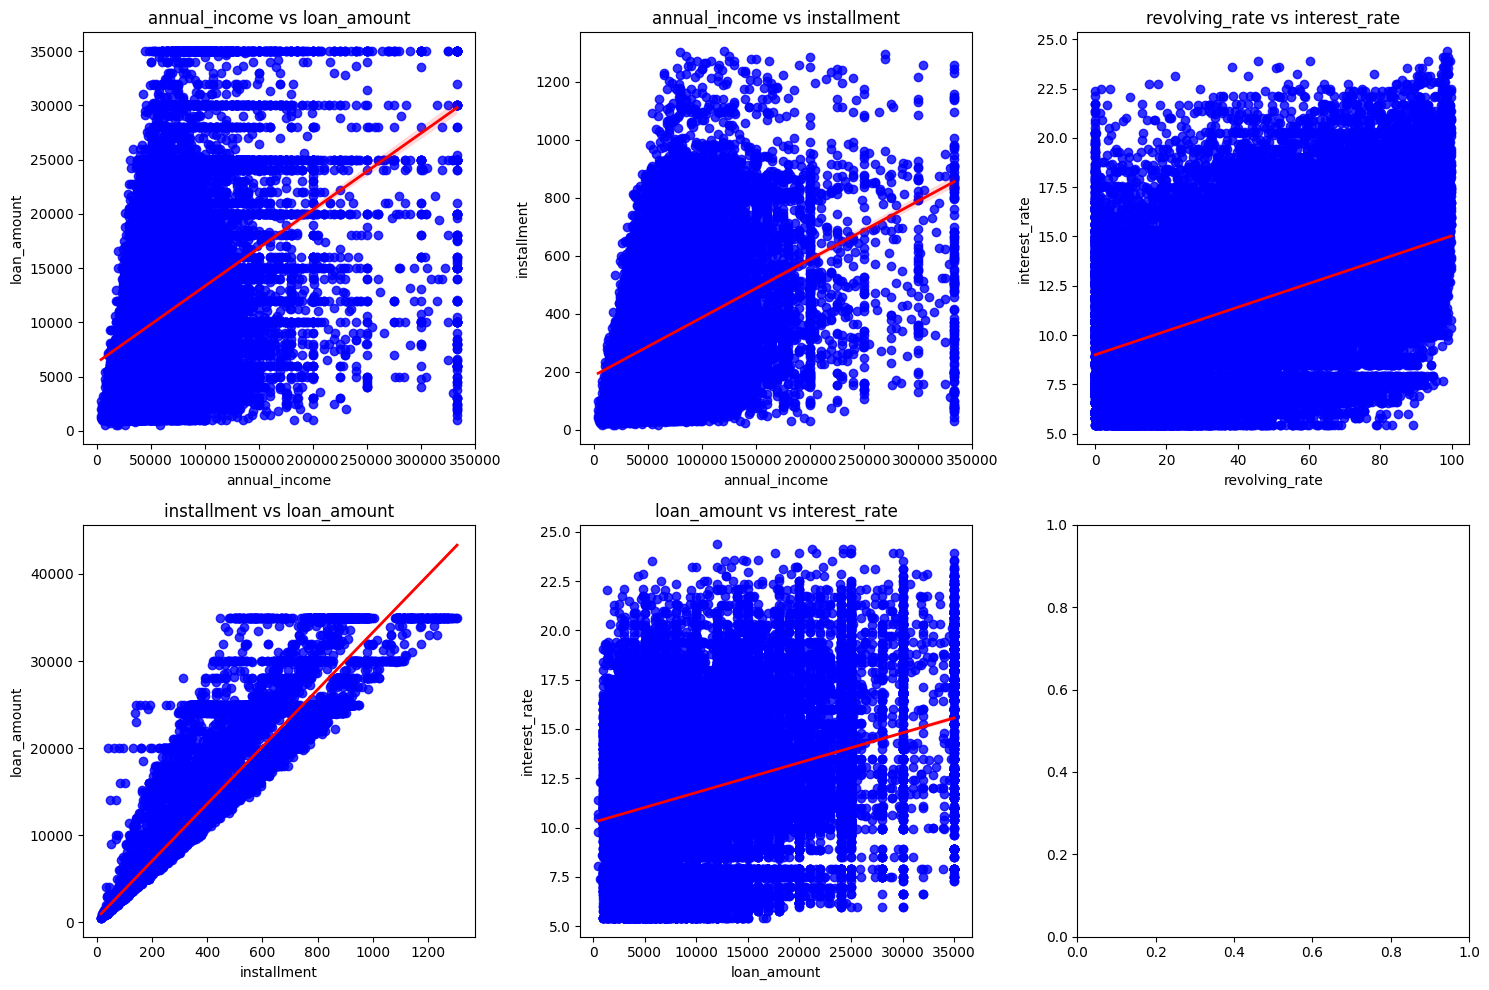

In [82]:
# Definir las columnas para el estudio
columnas_estudio = ['loan_amount', 'interest_rate', 'installment', 'revolving_rate', 'annual_income', 'dti']

# Seleccionar solo las columnas de interés del DataFrame
df_estudio = df_final[columnas_estudio]

# Crear un subplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Definir las combinaciones de columnas y sus posiciones en el subplot
columnas_combinaciones = [
    ('annual_income', 'loan_amount'),
    ('annual_income', 'installment'),
    ('revolving_rate', 'interest_rate'),
    ('installment', 'loan_amount'),
    ('loan_amount', 'interest_rate')
]

# Iterar sobre las combinaciones y trazar gráficos de dispersión con línea de tendencia
for i, combinacion in enumerate(columnas_combinaciones):
    row = i // 3
    col = i % 3
    sns.regplot(x=combinacion[0], y=combinacion[1], data=df_estudio, ax=axs[row, col], scatter_kws={"color": "blue"}, line_kws={"color":"red","linewidth":2})
    axs[row, col].set_title(f'{combinacion[0]} vs {combinacion[1]}')

# Ajustar diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

## Hipótesis de Desarrollo

La primera hipótesis es averiguar si el importe del préstamo tienen una incidencia significativa en el impago del mismo

'loan_amount' vs 'loan_status' ----> Test Mann-Whitney

H0: No hay evidencia significativa de que el importe del préstamo incide en el impago del mismo

H1: Hay una incidencia significativa en que el importe del préstamo incide en el impago del mismo

In [83]:
test_mann_whitney(df_final_paid, df_final_charged_off, 'loan_amount')

Estadístico Mann-Whitney: 85502980.0
Valor p: 1.0199505393221943e-20
Se rechaza la hipótesis nula: Hay diferencias significativas de la variable loan_amount entre pagados e impagados


La siguiente hipótesis es averiguar si el tipo de interés tienen una incidencia significativa en el impago del mismo

'interest_rate' vs 'loan_status' ----> Test Mann-Whitney

H0: No hay evidencia significativa de que el tipo de interés incide en el impago del mismo

H1: Hay una incidencia significativa en que el tipo de interés incide en el impago del mismo

In [84]:
test_mann_whitney(df_final_paid, df_final_charged_off, 'interest_rate')

Estadístico Mann-Whitney: 61878171.0
Valor p: 0.0
Se rechaza la hipótesis nula: Hay diferencias significativas de la variable interest_rate entre pagados e impagados


La siguiente hipótesis es averiguar si el importe de la cuota tienen una incidencia significativa en el impago del mismo

'installment' vs 'loan_status' ----> Test Mann-Whitney

H0: No hay evidencia significativa de que el importe de la cuota incide en el impago del mismo

H1: Hay una incidencia significativa en que el importe de la cuota incide en el impago del mismo

In [85]:
test_mann_whitney(df_final_paid, df_final_charged_off, 'installment')

Estadístico Mann-Whitney: 88999411.0
Valor p: 1.5910342038417275e-06
Se rechaza la hipótesis nula: Hay diferencias significativas de la variable installment entre pagados e impagados


La siguiente hipótesis es averiguar si el ratio DTI tienen una incidencia significativa en el impago del mismo

'dti' vs 'loan_status' ----> Test Mann-Whitney

H0: No hay evidencia significativa de que el ratio DTI incide en el impago del mismo

H1: Hay una incidencia significativa en que el ratio DTI incide en el impago del mismo

In [86]:
test_mann_whitney(df_final_paid, df_final_charged_off, 'dti')

Estadístico Mann-Whitney: 85648362.0
Valor p: 6.250688708615083e-20
Se rechaza la hipótesis nula: Hay diferencias significativas de la variable dti entre pagados e impagados


La siguiente hipótesis es averiguar si el grado de uso de las tarjetas revolving tienen una incidencia significativa en el impago del mismo

'revolving_rate' vs 'loan_status' ----> Test Mann-Whitney

H0: No hay evidencia significativa de que el el grado de uso de las tarjetas revolving incide en el impago del mismo

H1: Hay una incidencia significativa en que el grado de uso de las tarjetas revolving incide en el impago del mismo

In [87]:
test_mann_whitney(df_final_paid, df_final_charged_off, 'revolving_rate')

Estadístico Mann-Whitney: 77760623.5
Valor p: 1.789855795011887e-83
Se rechaza la hipótesis nula: Hay diferencias significativas de la variable revolving_rate entre pagados e impagados


La siguiente hipótesis es averiguar si el el tiempo que lleva empleado tienen una incidencia significativa en el impago del mismo

'employment_length' vs 'loan_status' ----> Prueba de independencia de Chi-Cuadrado

H0: No hay evidencia significativa de que el el tiempo que lleva empleado incide en el impago del mismo

H1: Hay una incidencia significativa en que el tiempo que lleva empleado incide en el impago del mismo

In [88]:
test_chi_cuadrado(df_final, 'employment_length')

Estadístico Chi-cuadrado: 22.33715483693283
Valor p: 0.007869693888138197
Se rechaza la hipótesis nula: la variable employment_length incide en en el impago del crédito


La siguiente hipótesis es averiguar si el el el régimen de vivienda tienen una incidencia significativa en el impago del mismo

'home_ownership' vs 'loan_status' ----> Prueba de independencia de Chi-Cuadrado

H0: No hay evidencia significativa de que el el régimen de vivienda incide en el impago del mismo

H1: Hay una incidencia significativa en que el régimen de vivienda incide en el impago del mismo

In [89]:
test_chi_cuadrado(df_final, 'home_ownership')

Estadístico Chi-cuadrado: 22.232937426753175
Valor p: 0.00018011714098862449
Se rechaza la hipótesis nula: la variable home_ownership incide en en el impago del crédito


La siguiente hipótesis es averiguar si el propósito para el que se concede el préstamo tienen una incidencia significativa en el impago del mismo

'purpose' vs 'loan_status' ----> Prueba de independencia de Chi-Cuadrado

H0: No hay evidencia significativa de que el propósito para el que se concede el préstamo incide en el impago del mismo

H1: Hay una incidencia significativa en que el propósito para el que se concede el préstamo incide en el impago del mismo

In [90]:
test_chi_cuadrado(df_final, 'purpose')

Estadístico Chi-cuadrado: 378.9439492892116
Valor p: 6.213959204644354e-73
Se rechaza la hipótesis nula: la variable purpose incide en en el impago del crédito


La última hipótesis es averiguar si los ingresos anuales tienen una incidencia significativa en el impago del mismo

'annual_income' vs 'loan_status' ----> Test Mann-Whitney

H0: No hay evidencia significativa de que los ingresos anuales incide en el impago del mismo

H1: Hay una incidencia significativa en que los ingresos anuales incide en el impago del mismo

In [91]:
test_mann_whitney(df_final_paid, df_final_charged_off, 'annual_income')

Estadístico Mann-Whitney: 103349135.5
Valor p: 2.9995346838200955e-43
Se rechaza la hipótesis nula: Hay diferencias significativas de la variable annual_income entre pagados e impagados


## CONCLUSIONES

Del análisis de nuestras variables podemos extraer las siguientes conclusiones:

1. En todas las variables estudiadas hemos rechazado la hipótesis nula, por lo que todas ellas tienen una incidencia significativa en que el préstamo resulte impagado.
2. Dado que tenemos una serie de variables independientes de tipo numérico y continuas y otras de tipo categórico, y una variables dependiente de tipo categórico divisible en dos grupos, y puesto que todas las variables indpendientes tienen una incidencia significativa en la variable dependiente, podríamos hacer una regresión de tipo logístico que nos sirviera de modelo para explicar y preveer la posibilidad de impago de un préstamo.
3. Una vez que obtengamos el modelo a través de la regresión logísitica, podemos aplicarlo, mediante un modelo de Machine learning, al dataset de los préstamos que no están vencidos aún, de manera que podamos preveer aquellos créditos con mayor probabilidad de impago, a fin de tomar las medidas preventivas necesarias y disminuir las pérdidas por impago.
4. El modelo obtenido puede difundirse entre los empleados responsables de aprobar los créditos, a fin de disminuir la probabilidad de impago, así como del departamento de incobrables, a fin de que tomen medidas preventivas sobre los créditos de mayor riesgo.